In [1]:
from utils.kernel import RBFKernel, LinearKernel, Matern52Kernel
from utils.gaussian_process import GaussianProcess as GP
import numpy as np
import pandas as pd
import scanpy as sc
import os
import scvelo as scv
import matplotlib.pyplot as plt
import random
random.seed(2020)

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==0.24.2 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
adata = sc.read("write/DentateGyrus_1.h5ad")
adata

AnnData object with n_obs × n_vars = 5838 × 3223 
    obs: 'ClusterName', 'Clusters', 'Date_Captured', 'TSNE1', 'TSNE2', 'n_counts', 'n_genes', 'percent_mito'
    var: 'genes', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'all_genes'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [4]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Normalized count data: spliced, unspliced.
computing PCA with n_comps = 30
    on highly variable genes
    finished (0:00:00)
computing neighbors
    finished (0:00:02) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


In [5]:
scv.tl.recover_dynamics(adata)

recovering dynamics
    finished (0:27:40) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [6]:
scv.tl.velocity(adata, mode='dynamical')

computing velocities
    finished (0:00:10) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [7]:
scv.tl.velocity_graph(adata)

computing velocity graph
    finished (0:00:24) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [9]:
### Check Point
# adata.write("write/Dentate_Gyrus_dynamical.h5ad")
# adata = sc.read_h5ad("write/Dentate_Gyrus_dynamical.h5ad")

In [15]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)


In [49]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


In [66]:
adata

AnnData object with n_obs × n_vars = 5838 × 3223 
    obs: 'ClusterName', 'Clusters', 'Date_Captured', 'TSNE1', 'TSNE2', 'n_counts', 'n_genes', 'percent_mito', 'velocity_self_transition', 'louvain'
    var: 'genes', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'all_genes', 'pca', 'neighbors', 'recover_dynamics', 'velocity_settings', 'velocity_graph', 'velocity_graph_neg', 'umap', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'velocity_pca', 'X_umap', 'velocity_umap', 'X_tsne', 'velocity_tsne'
    varm: 'PCs', 'loss'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'

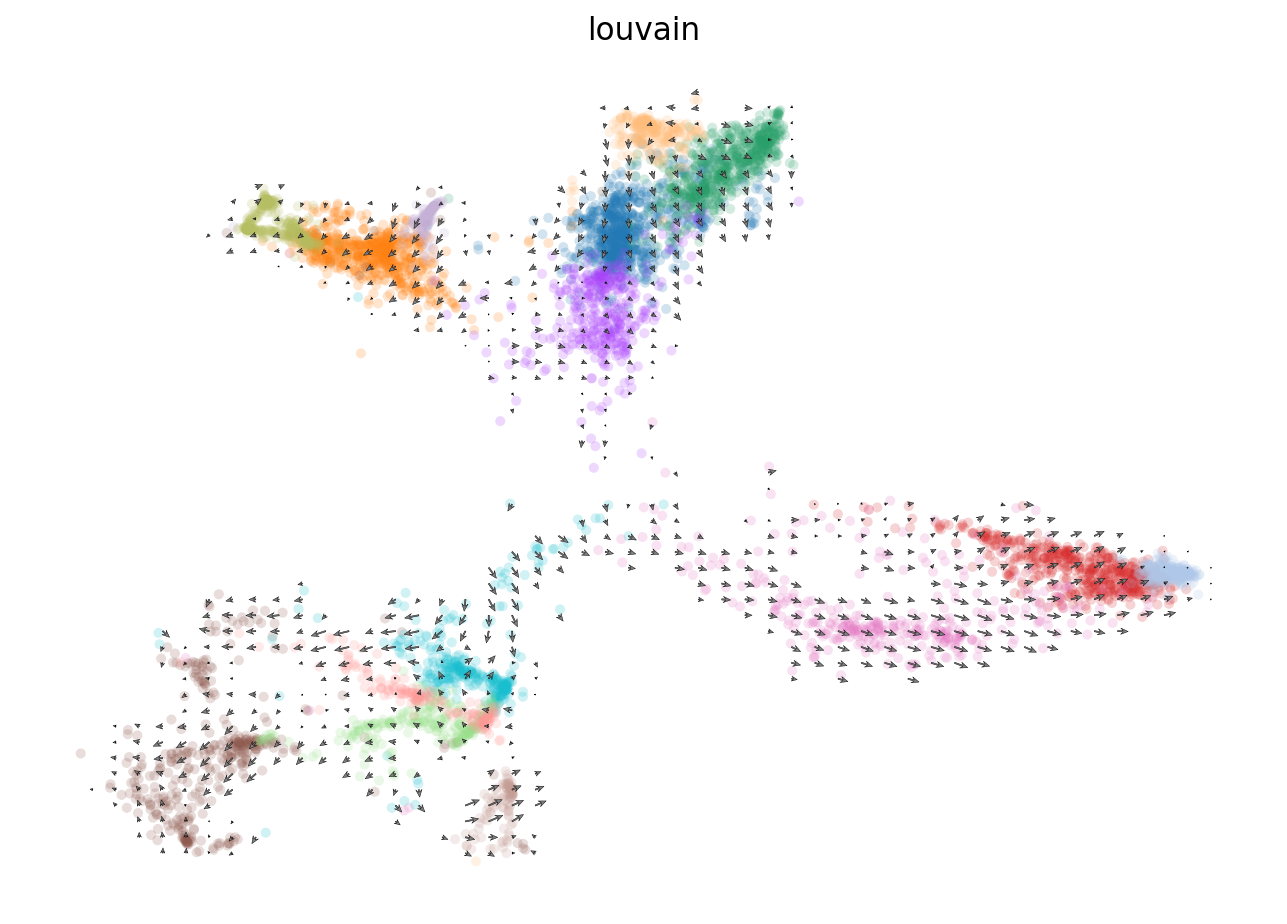

In [79]:
scv.pl.velocity_embedding_grid(adata, basis='tsne', figsize=(10, 7))

In [80]:
def loss(true, pred, penalize_0s=True):
    error = np.square(true - pred)
    if not penalize_0s:
        error =  error[true != 0]
    return np.sqrt(np.mean(error))

# Baseline Gassian Process

    1. Using the RBF (Squared Exponent) Kernel
    2. 70% of dataset as it's smaller as it's very sparse
    3. Optimize only for first gene in list

In [96]:
kernel = RBFKernel(alpha=0.1, gamma=1)
gp = GP(kernel=kernel, alpha=1e-5, optimize=True, restarts=0)

In [100]:
genes = {gene:i for i, gene in enumerate(list(adata.var["velocity_genes"].index)) if adata.var["velocity_genes"][gene]}
GENES = list(genes.keys())

In [101]:
error = []
error_weighted = []

X = adata.obsm["X_tsne"][:, :2]

In [102]:
#### Optimize for random gene
random_gene = np.random.choice(GENES)
print(random_gene)
y = adata.X.A[:, genes[random_gene]].reshape(-1)
Y = y
gp.fit(X, Y.reshape(-1, 1), sample_ratio=0.4)
kernel.gamma

Cdh10


array([2.99138441, 3.14395798])

In [103]:
#### Fit On All Genes
data = adata.X.A
for gene in GENES:
    y = data[:, genes[gene]].reshape(-1)
    Y = y
    gp.fit(X, Y.reshape(-1, 1), sample_ratio=0.4)
    gp.log_marginal_likelihood(gene, info=True)
    pred = gp.predict(X)
    error.append(np.sqrt(np.mean(np.square(y - pred))))
    error_weighted.append(loss(y, pred, penalize_0s=False))

Gene: Rgs20        Marginal Likelihood: [-3599.22809852]
Gene: Mybl1        Marginal Likelihood: [-2354.72111427]
Gene: Ogfrl1       Marginal Likelihood: [-6031.07528875]
Gene: Prim2        Marginal Likelihood: [-2939.48847695]
Gene: 2010300C02Rik Marginal Likelihood: [-3176.90589421]
Gene: Creg2        Marginal Likelihood: [-3880.30737236]
Gene: Pantr1       Marginal Likelihood: [-6382.57536795]
Gene: Fhl2         Marginal Likelihood: [-3772.75829902]
Gene: Tex30        Marginal Likelihood: [-4260.18249423]
Gene: Col5a2       Marginal Likelihood: [-2612.38158807]
Gene: Stk17b       Marginal Likelihood: [-2678.71683248]
Gene: Rftn2        Marginal Likelihood: [-3278.69746438]
Gene: Klf7         Marginal Likelihood: [-11335.18795327]
Gene: Idh1         Marginal Likelihood: [-9839.31938894]
Gene: Acadl        Marginal Likelihood: [-3305.3701606]
Gene: Bard1        Marginal Likelihood: [-2375.80142467]
Gene: Fn1          Marginal Likelihood: [-2534.44593268]
Gene: Tns1         Marginal Li

Gene: Parpbp       Marginal Likelihood: [-2358.4803434]
Gene: Gas2l3       Marginal Likelihood: [-2645.48488396]
Gene: Tmpo         Marginal Likelihood: [-5137.385033]
Gene: Nedd1        Marginal Likelihood: [-2553.98798607]
Gene: Nudt4        Marginal Likelihood: [-4844.76425675]
Gene: Syt1         Marginal Likelihood: [-6852.76847786]
Gene: Kif5a        Marginal Likelihood: [-6111.29634102]
Gene: Rbms2        Marginal Likelihood: [-2676.39686581]
Gene: Ppp1r14c     Marginal Likelihood: [-8314.36562084]
Gene: Akap12       Marginal Likelihood: [-3159.78849116]
Gene: Plagl1       Marginal Likelihood: [-2805.04700104]
Gene: Map7         Marginal Likelihood: [-2352.76725796]
Gene: Epb41l2      Marginal Likelihood: [-2926.26715751]
Gene: Wasf1        Marginal Likelihood: [-7171.87246101]
Gene: Snx3         Marginal Likelihood: [-10266.22371256]
Gene: Gja1         Marginal Likelihood: [-4437.06684929]
Gene: Pkib         Marginal Likelihood: [-3051.87097621]
Gene: Smpdl3a      Marginal Likel

Gene: Bzw2         Marginal Likelihood: [-10075.93568639]
Gene: Stxbp6       Marginal Likelihood: [-4253.35080113]
Gene: Nova1        Marginal Likelihood: [-3137.74341526]
Gene: Egln3        Marginal Likelihood: [-2368.71392914]
Gene: Baz1a        Marginal Likelihood: [-2633.35358632]
Gene: Nfkbia       Marginal Likelihood: [-4837.22697036]
Gene: Mis18bp1     Marginal Likelihood: [-2913.80741583]
Gene: Dnaaf2       Marginal Likelihood: [-3635.38906971]
Gene: Pole2        Marginal Likelihood: [-2329.94834976]
Gene: Cdkl1        Marginal Likelihood: [-2751.28129111]
Gene: Trim9        Marginal Likelihood: [-4255.88666012]
Gene: Sptb         Marginal Likelihood: [-2369.56329386]
Gene: Zfp36l1      Marginal Likelihood: [-4218.63832906]
Gene: Actn1        Marginal Likelihood: [-3428.47537731]
Gene: Pgf          Marginal Likelihood: [-2578.66053336]
Gene: Dio2         Marginal Likelihood: [-2773.35296434]
Gene: Bcl11b       Marginal Likelihood: [-6789.12392527]
Gene: Itgb8        Marginal Li

Gene: Rnaseh2b     Marginal Likelihood: [-3501.3252131]
Gene: Fam124a      Marginal Likelihood: [-3840.51219118]
Gene: Fam167a      Marginal Likelihood: [-2608.05431807]
Gene: Zfp395       Marginal Likelihood: [-2441.28230244]
Gene: Clu          Marginal Likelihood: [-4598.42252558]
Gene: Phyhip       Marginal Likelihood: [-3875.29900788]
Gene: Lgi3         Marginal Likelihood: [-2420.68611532]
Gene: Gfra2        Marginal Likelihood: [-3594.67830882]
Gene: Ccdc122      Marginal Likelihood: [-2349.10129641]
Gene: Elf1         Marginal Likelihood: [-2436.87228811]
Gene: Pcdh17       Marginal Likelihood: [-6595.40535511]
Gene: Bora         Marginal Likelihood: [-2492.48181464]
Gene: Klf5         Marginal Likelihood: [-2314.10221184]
Gene: Cldn10       Marginal Likelihood: [-2862.56921878]
Gene: Dnajc3       Marginal Likelihood: [-3650.61306485]
Gene: Slc1a3       Marginal Likelihood: [-7145.71338693]
Gene: Skp2         Marginal Likelihood: [-3101.59063724]
Gene: Ncald        Marginal Like

Gene: Ptk7         Marginal Likelihood: [-2881.9199807]
Gene: Daam2        Marginal Likelihood: [-2510.12613456]
Gene: Satb1        Marginal Likelihood: [-4218.91955798]
Gene: Sgol1        Marginal Likelihood: [-2737.74449618]
Gene: Rab31        Marginal Likelihood: [-3665.30539207]
Gene: Myl12a       Marginal Likelihood: [-5995.22978216]
Gene: Smchd1       Marginal Likelihood: [-5574.82148253]
Gene: Ndc80        Marginal Likelihood: [-2336.56639808]
Gene: Eif2ak2      Marginal Likelihood: [-2342.41136268]
Gene: Prkd3        Marginal Likelihood: [-3859.18134276]
Gene: Cdc42ep3     Marginal Likelihood: [-3669.18200361]
Gene: Cyp1b1       Marginal Likelihood: [-2821.11270216]
Gene: Lix1         Marginal Likelihood: [-4867.70146981]
Gene: Pkmyt1       Marginal Likelihood: [-2675.46244152]
Gene: Eci1         Marginal Likelihood: [-3047.65175621]
Gene: Gng13        Marginal Likelihood: [-2849.47411368]
Gene: Pacsin1      Marginal Likelihood: [-4027.70481061]
Gene: Pim1         Marginal Like

Gene: Nacc2        Marginal Likelihood: [-3100.51764237]
Gene: Notch1       Marginal Likelihood: [-3882.77826546]
Gene: Fam163b      Marginal Likelihood: [-4242.09741236]
Gene: Sardh        Marginal Likelihood: [-2317.55863335]
Gene: Dnm1         Marginal Likelihood: [-3899.45570842]
Gene: Stom         Marginal Likelihood: [-2436.69895019]
Gene: Nmi          Marginal Likelihood: [-2315.37360896]
Gene: Nr4a2        Marginal Likelihood: [-3933.44694318]
Gene: Acvr1c       Marginal Likelihood: [-2581.06167657]
Gene: Wdsub1       Marginal Likelihood: [-2329.95617479]
Gene: Rbms1        Marginal Likelihood: [-3074.98398066]
Gene: Grb14        Marginal Likelihood: [-3503.11211767]
Gene: Scn3a        Marginal Likelihood: [-5893.81353817]
Gene: Scn1a        Marginal Likelihood: [-2688.3390288]
Gene: Spc25        Marginal Likelihood: [-2365.21546763]
Gene: Wipf1        Marginal Likelihood: [-2361.29519488]
Gene: Nfe2l2       Marginal Likelihood: [-2567.90125459]
Gene: Neurod1      Marginal Like

Gene: Golim4       Marginal Likelihood: [-3252.72008938]
Gene: Rxfp1        Marginal Likelihood: [-2276.63013454]
Gene: Tmem144      Marginal Likelihood: [-2463.08782027]
Gene: Gucy1b3      Marginal Likelihood: [-3721.66957233]
Gene: Gucy1a3      Marginal Likelihood: [-3006.20646728]
Gene: Arfip1       Marginal Likelihood: [-2732.64790989]
Gene: Pmf1         Marginal Likelihood: [-3305.7447058]
Gene: Syt11        Marginal Likelihood: [-10813.52068554]
Gene: Efna1        Marginal Likelihood: [-2402.66930184]
Gene: Gabpb2       Marginal Likelihood: [-2527.94601472]
Gene: Plekho1      Marginal Likelihood: [-3460.96608704]
Gene: Ttf2         Marginal Likelihood: [-2366.11832197]
Gene: Ptgfrn       Marginal Likelihood: [-2900.74159292]
Gene: Rbm15        Marginal Likelihood: [-2916.69666889]
Gene: Kcnc4        Marginal Likelihood: [-2507.60119764]
Gene: Csf1         Marginal Likelihood: [-2336.06667146]
Gene: Gpsm2        Marginal Likelihood: [-2968.76496235]
Gene: Ntng1        Marginal Lik

Gene: Hsdl2        Marginal Likelihood: [-4075.1013747]
Gene: E130308A19Rik Marginal Likelihood: [-2760.75729569]
Gene: Lurap1l      Marginal Likelihood: [-2698.65314747]
Gene: Cntln        Marginal Likelihood: [-3122.66070033]
Gene: Mtap         Marginal Likelihood: [-2972.86412271]
Gene: Ift74        Marginal Likelihood: [-3685.36069751]
Gene: Hook1        Marginal Likelihood: [-2719.08567125]
Gene: Usp1         Marginal Likelihood: [-4858.21081605]
Gene: Plpp3        Marginal Likelihood: [-6888.34931693]
Gene: Usp24        Marginal Likelihood: [-3496.58841089]
Gene: Ssbp3        Marginal Likelihood: [-5999.06137184]
Gene: Lrp8         Marginal Likelihood: [-5697.13632008]
Gene: Echdc2       Marginal Likelihood: [-2298.41656828]
Gene: Spata6       Marginal Likelihood: [-2379.90054776]
Gene: Stil         Marginal Likelihood: [-2422.78960222]
Gene: Pik3r3       Marginal Likelihood: [-3803.52909746]
Gene: Hpcal4       Marginal Likelihood: [-3503.42561917]
Gene: Grik3        Marginal Lik

Gene: Anxa4        Marginal Likelihood: [-2417.57795013]
Gene: Cfap100      Marginal Likelihood: [-2348.13202923]
Gene: Lrig1        Marginal Likelihood: [-2504.43530488]
Gene: Suclg2       Marginal Likelihood: [-2779.63111755]
Gene: Foxp1        Marginal Likelihood: [-5037.09965001]
Gene: Rad18        Marginal Likelihood: [-2484.55943285]
Gene: Atp2b2       Marginal Likelihood: [-4565.68240314]
Gene: Wnk1         Marginal Likelihood: [-5075.37929589]
Gene: Ccdc77       Marginal Likelihood: [-2804.82031239]
Gene: Apobec1      Marginal Likelihood: [-2356.31536218]
Gene: Eno2         Marginal Likelihood: [-3977.19962055]
Gene: Ncapd2       Marginal Likelihood: [-2720.22455026]
Gene: Cd9          Marginal Likelihood: [-7119.82920102]
Gene: Ntf3         Marginal Likelihood: [-3180.80507714]
Gene: Kcna6        Marginal Likelihood: [-3412.06563854]
Gene: Rad51ap1     Marginal Likelihood: [-2751.14623443]
Gene: Prmt8        Marginal Likelihood: [-4564.91534085]
Gene: Tspan9       Marginal Lik

Gene: Tead2        Marginal Likelihood: [-3412.74227299]
Gene: Slc17a6      Marginal Likelihood: [-3444.15196997]
Gene: Luzp2        Marginal Likelihood: [-3450.84527085]
Gene: Gabrb3       Marginal Likelihood: [-6538.27675727]
Gene: Chsy1        Marginal Likelihood: [-3599.2258408]
Gene: Rgma         Marginal Likelihood: [-4608.89299762]
Gene: Acan         Marginal Likelihood: [-2387.96779365]
Gene: AI854517     Marginal Likelihood: [-5029.31816042]
Gene: RP23-207N5.2 Marginal Likelihood: [-3069.36945601]
Gene: Prc1         Marginal Likelihood: [-3298.45721853]
Gene: Sh3gl3       Marginal Likelihood: [-6586.44970384]
Gene: Me3          Marginal Likelihood: [-3062.11800768]
Gene: Tenm4        Marginal Likelihood: [-5761.89150699]
Gene: Pgm2l1       Marginal Likelihood: [-4736.253271]
Gene: C2cd3        Marginal Likelihood: [-2569.30041706]
Gene: Rrm1         Marginal Likelihood: [-3355.25864176]
Gene: Tub          Marginal Likelihood: [-5780.13861085]
Gene: Swap70       Marginal Likeli

Gene: Zic1         Marginal Likelihood: [-2909.70923117]
Gene: 1190002N15Rik Marginal Likelihood: [-2671.76028826]
Gene: Rasa2        Marginal Likelihood: [-3635.09257835]
Gene: Mras         Marginal Likelihood: [-4943.70843496]
Gene: Ephb1        Marginal Likelihood: [-4507.71839254]
Gene: Gnai2        Marginal Likelihood: [-6377.39528163]
Gene: Slc38a3      Marginal Likelihood: [-3051.19348601]
Gene: Crtap        Marginal Likelihood: [-2359.44168365]
Gene: Stt3b        Marginal Likelihood: [-5247.55117694]
Gene: Maml2        Marginal Likelihood: [-3332.41201317]
Gene: Fam76b       Marginal Likelihood: [-3729.41811358]
Gene: Sesn3        Marginal Likelihood: [-4264.40876289]
Gene: Mre11a       Marginal Likelihood: [-2631.11007302]
Gene: Pde4a        Marginal Likelihood: [-3854.09879598]
Gene: Eepd1        Marginal Likelihood: [-2986.57649568]
Gene: Ncapd3       Marginal Likelihood: [-3043.11885396]
Gene: Cdon         Marginal Likelihood: [-2776.50008614]
Gene: Tmem218      Marginal Li

### Rank Genes by Smoothness

Get top and last 10 genes by smoothness

In [104]:
lh = gp.get_all_likelihoods()
top = list(zip(*sorted(list(lh.items()), key=lambda x:x[1], reverse=True)))[0]
last = top[::-1]
top[:10]

('Vgll3',
 'Aifm3',
 'Asap3',
 'Rxfp1',
 'Slc2a9',
 'Stc2',
 'Inpp5j',
 'Cntnap1',
 'Rarb',
 'Ap1s3')

In [105]:
last[:10]

('Ctnnbip1',
 'Klf7',
 'Gm17750',
 'Syt11',
 'Thra',
 'Gabra2',
 'Dcx',
 'Arl6ip1',
 'Snx3',
 'Dctn3')

### Inspect Corelation Between Genes

Plot the correlation between top 3:

    1. smoothest and least smooth genes
    2. smoothest and smoothest genes
    3. lest smooth and leat smooth genes

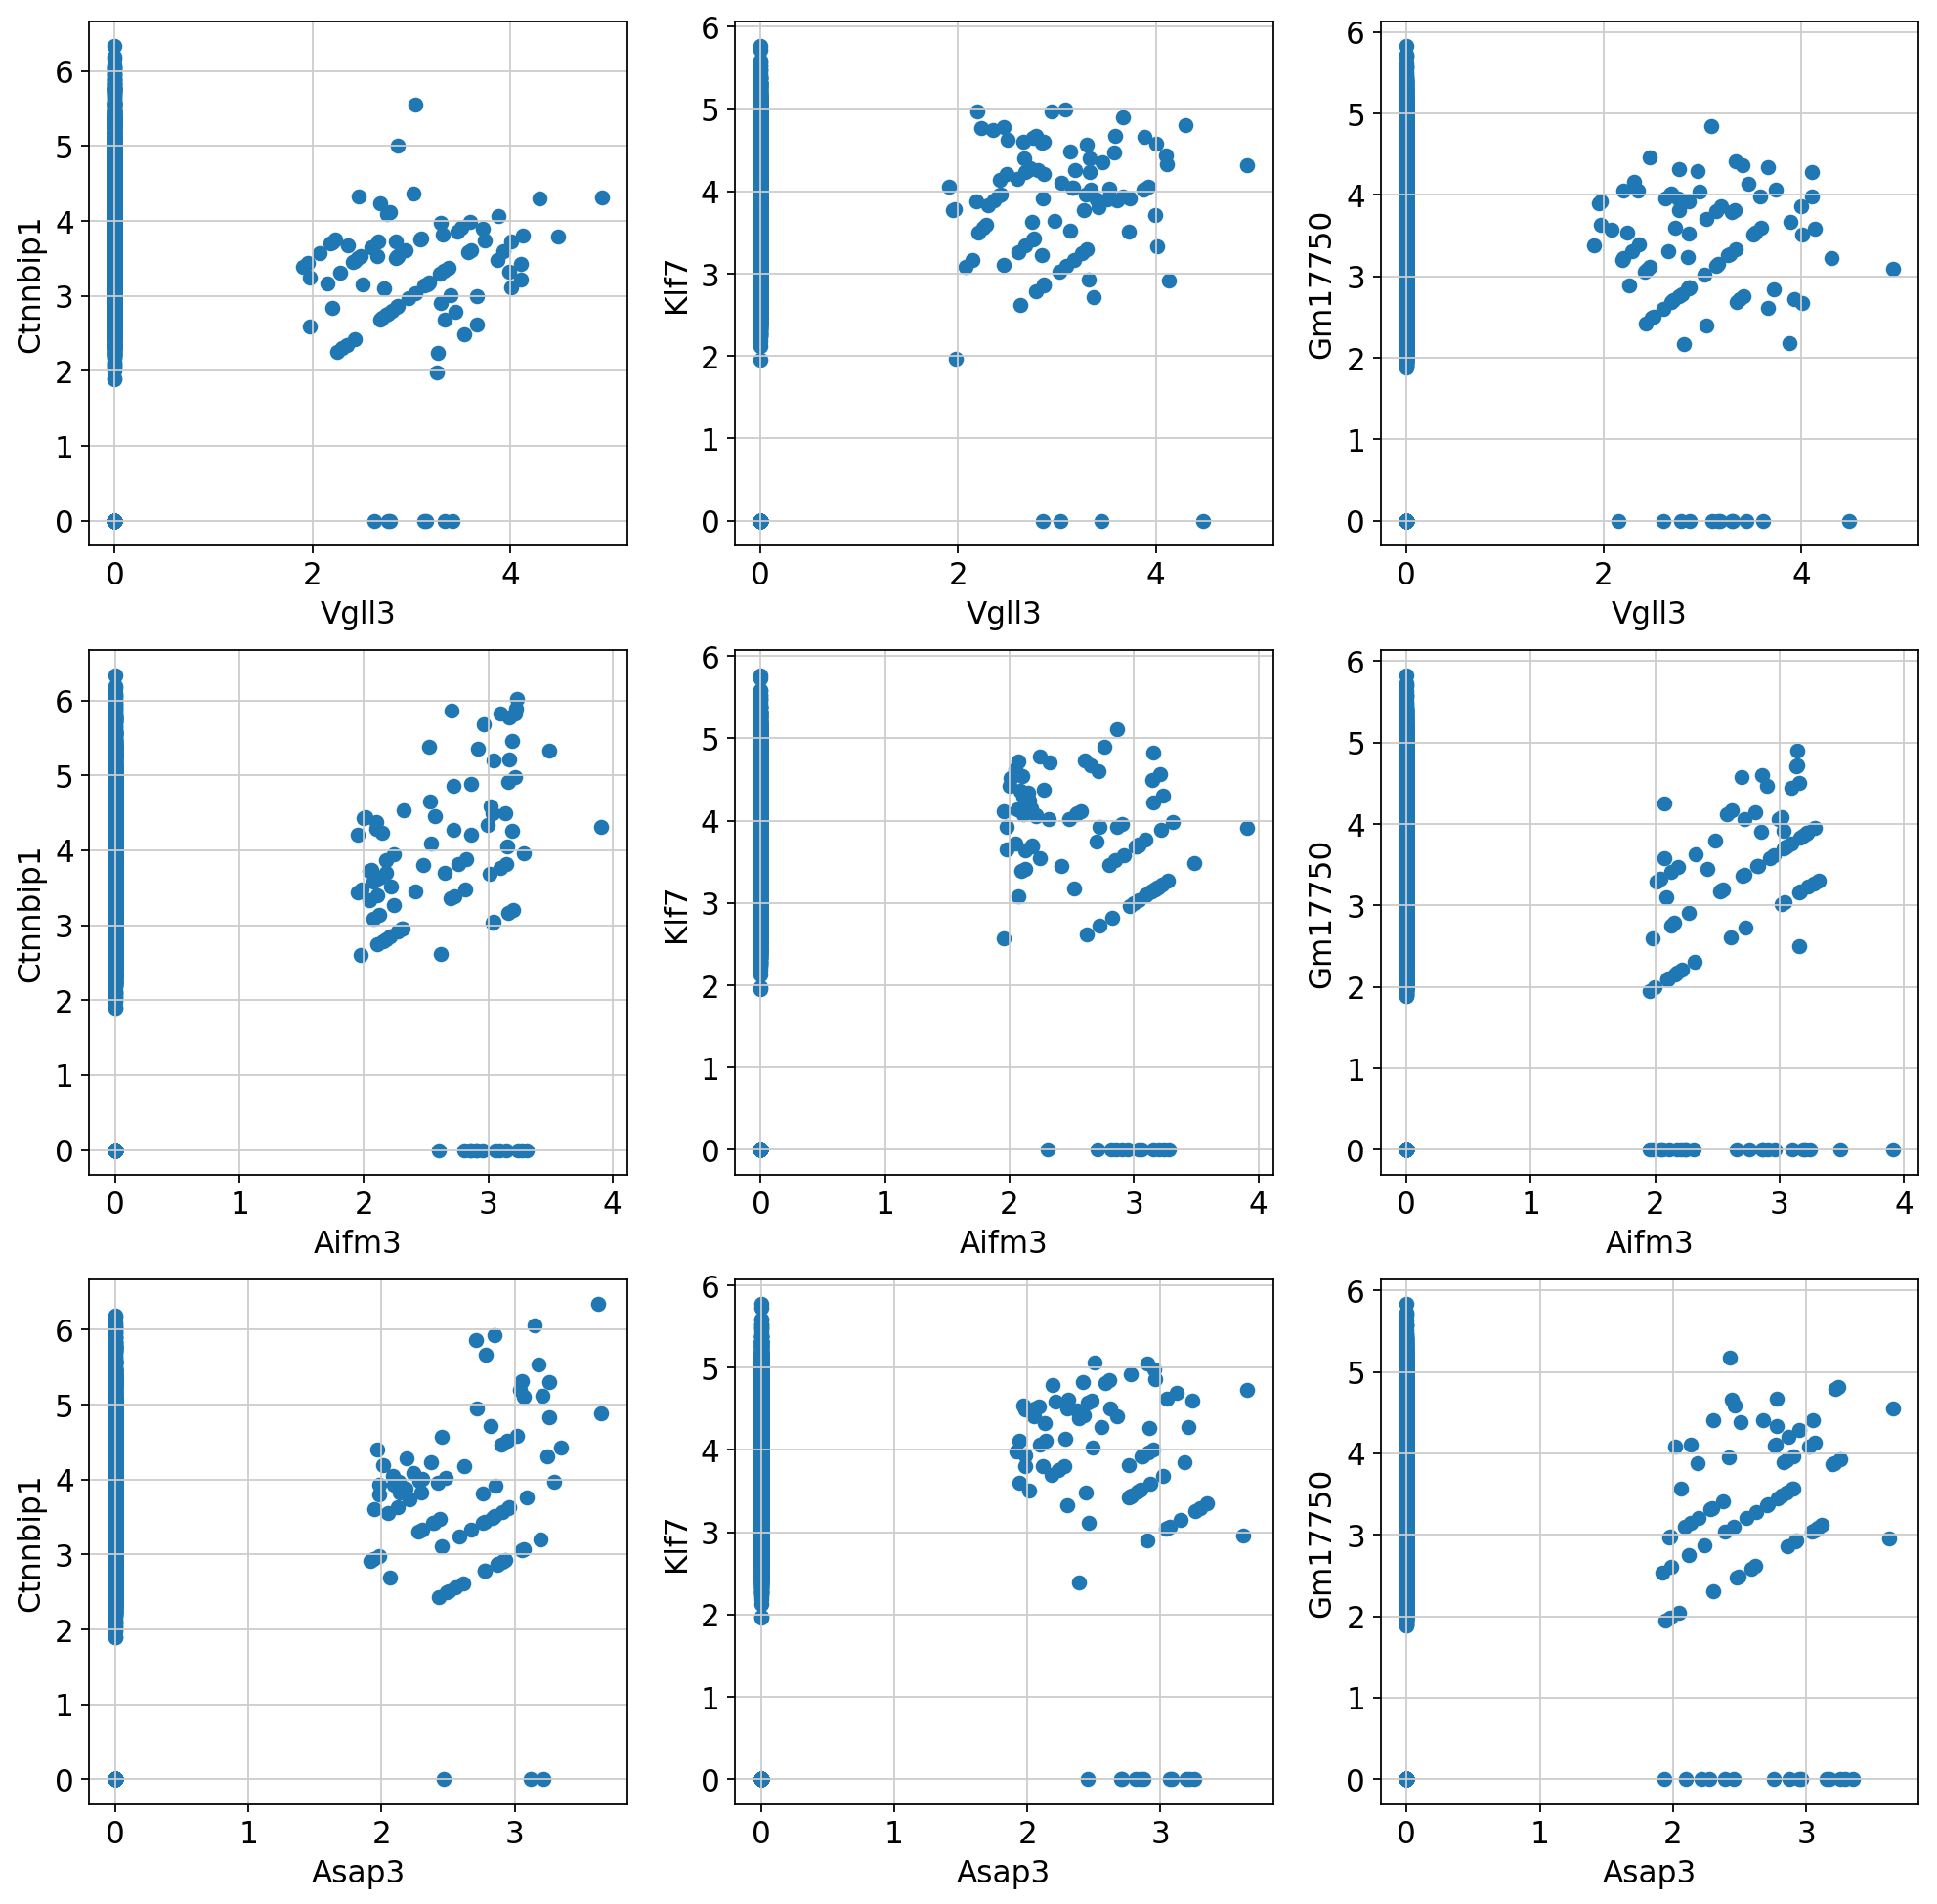

In [106]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, genei in enumerate(top[:3]):
    for j, genej in enumerate(last[:3]):
        ax[i][j].scatter(adata.X[:, genes[genei]].A, adata.X[:, genes[genej]].A)
        ax[i][j].set_xlabel(genei)
        ax[i][j].set_ylabel(genej)

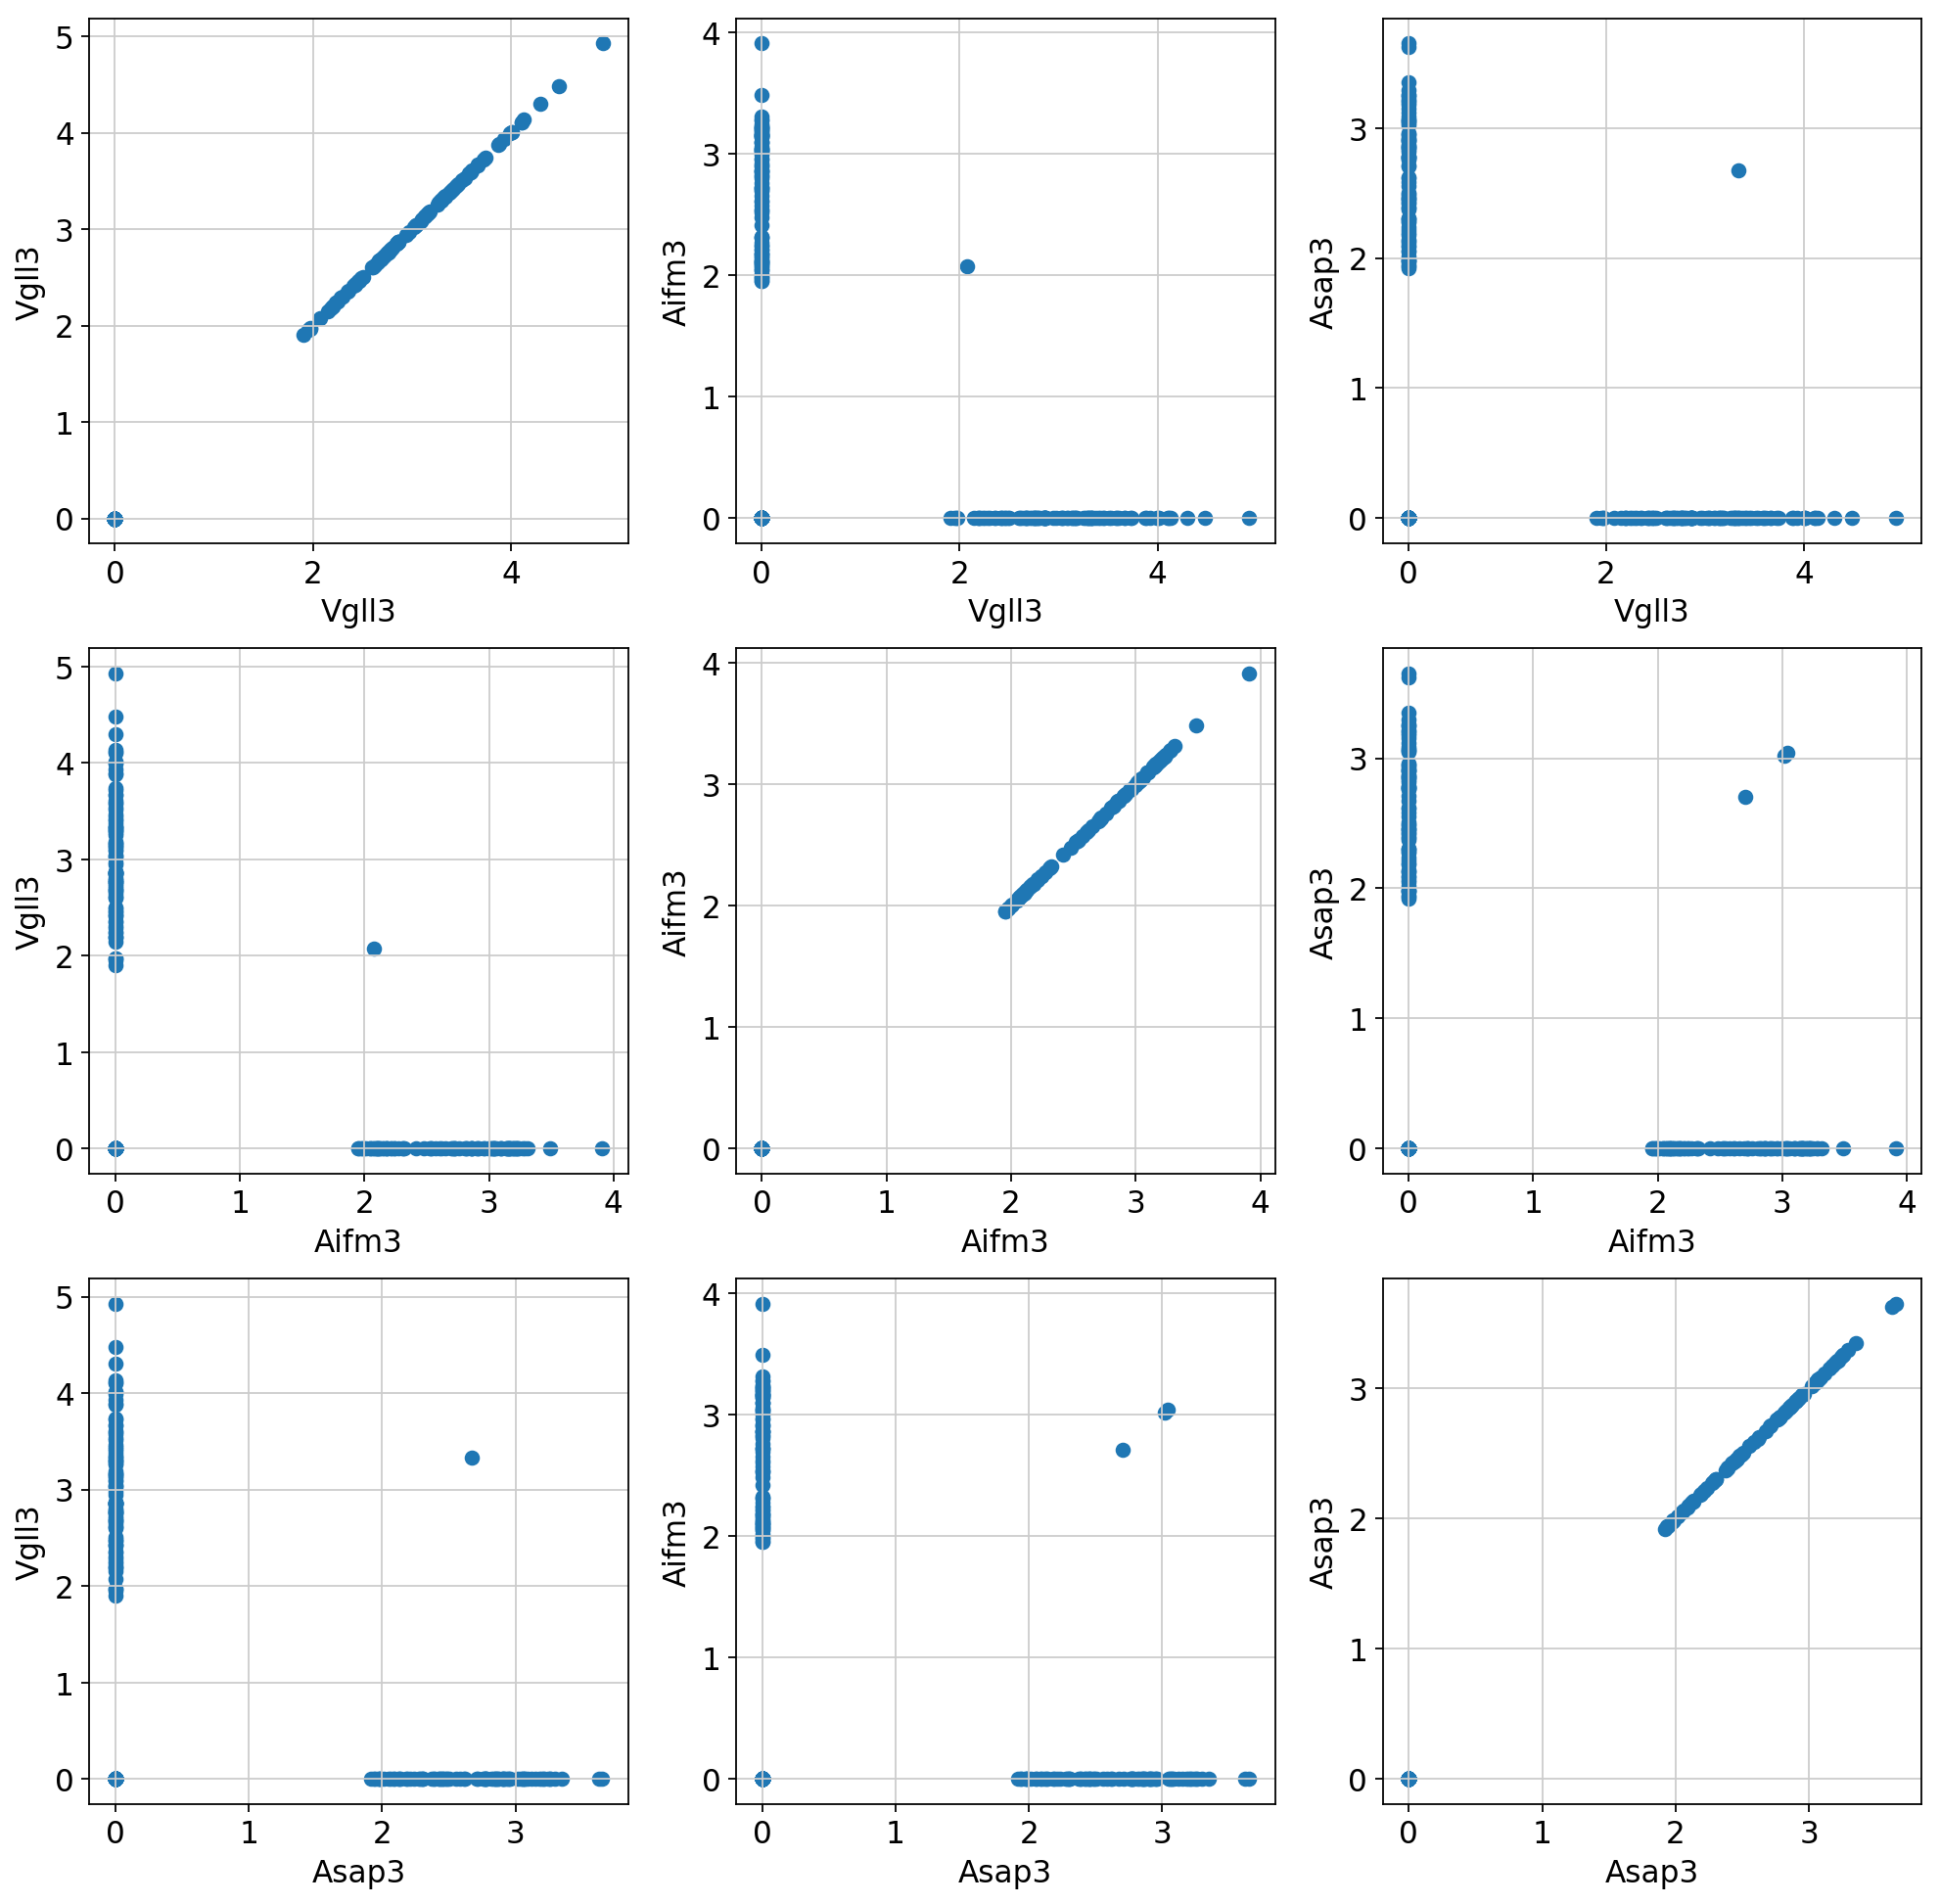

In [107]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, genei in enumerate(top[:3]):
    for j, genej in enumerate(top[:3]):
        ax[i][j].scatter(adata.X[:, genes[genei]].A, adata.X[:, genes[genej]].A)
        ax[i][j].set_xlabel(genei)
        ax[i][j].set_ylabel(genej)

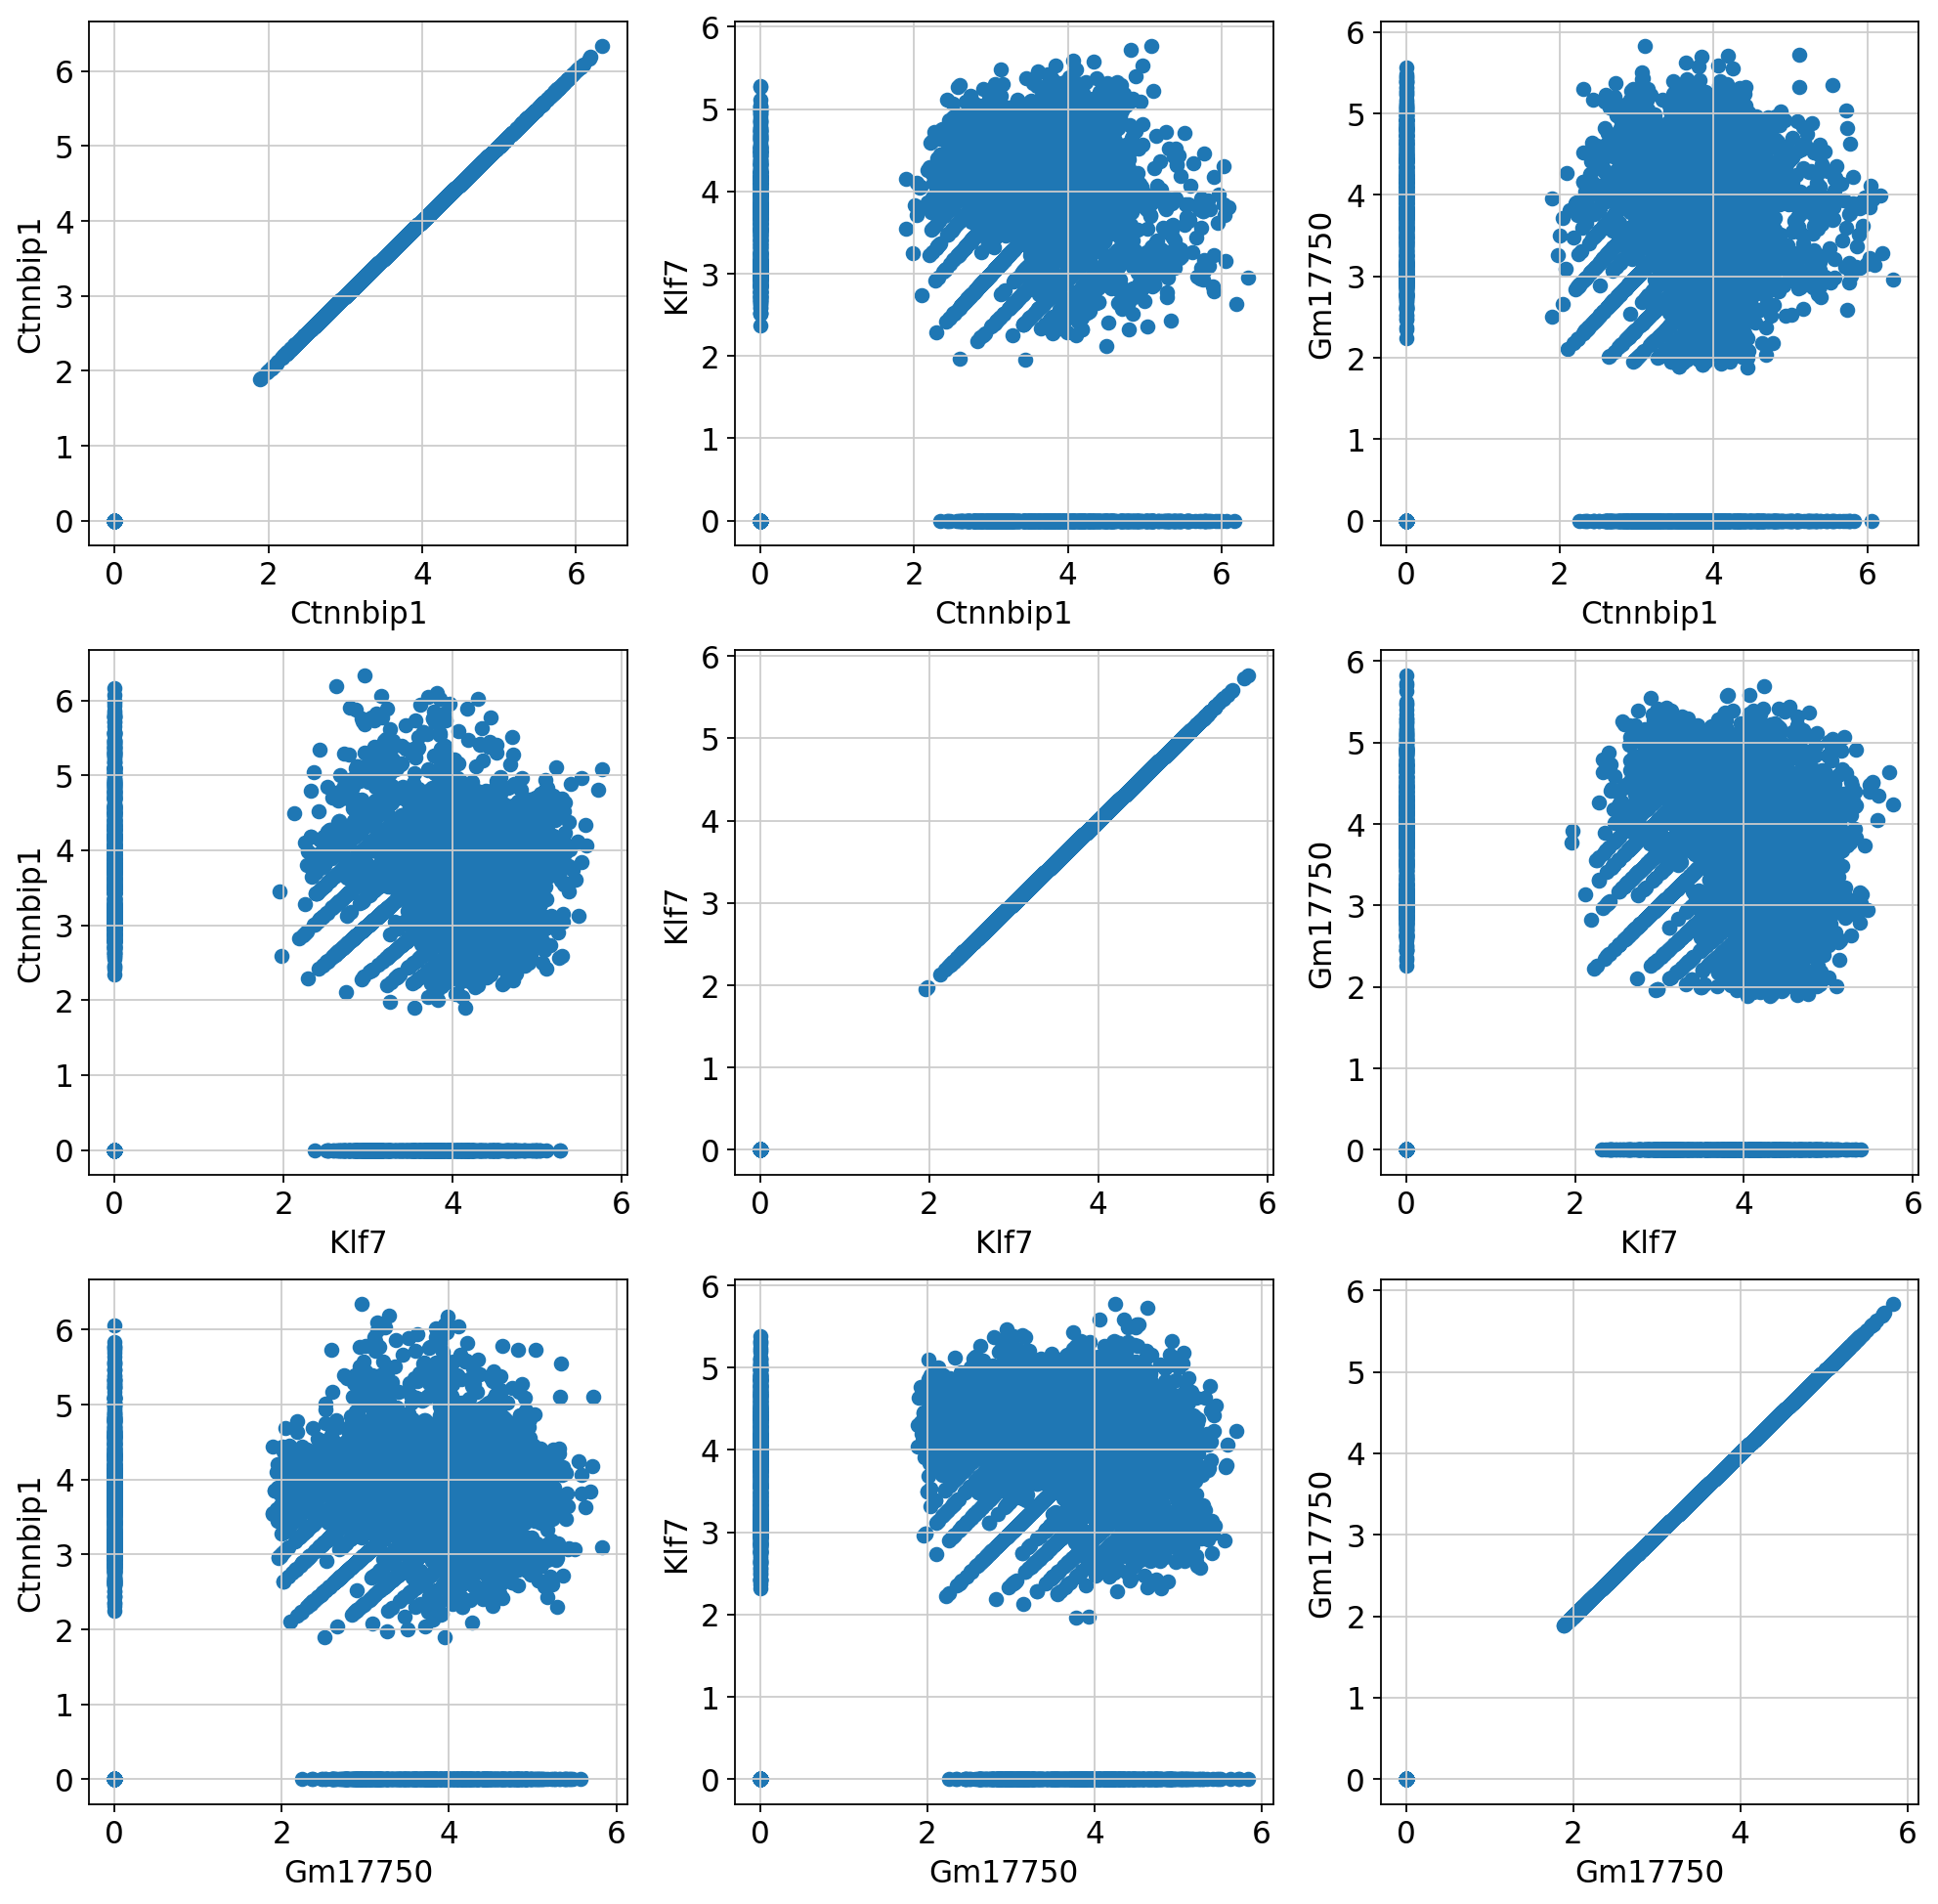

In [108]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, genei in enumerate(last[:3]):
    for j, genej in enumerate(last[:3]):
        ax[i][j].scatter(adata.X[:, genes[genei]].A, adata.X[:, genes[genej]].A)
        ax[i][j].set_xlabel(genei)
        ax[i][j].set_ylabel(genej)

# Gaussian Process with RNA Velocity Observations

Enhance the model by adding RNA Velocities

    1. Use only 40% of the dataset as it's very sparse

In [109]:
kernel_do = RBFKernel(alpha=0.1, gamma=1)
gp_do = GP(kernel=kernel_do, derivative_observations=True, optimize=False)

In [110]:
errors_do = []
weighted_errors_do = []

X = adata.obsm["X_tsne"][:, :2]
dy_x1 = adata.obsm["velocity_tsne"][:, 0]
dy_x2 = adata.obsm["velocity_tsne"][:, 1]

In [111]:
# Use the same gammas as in the baseline model
gp_do.gamma = gp.kernel.gamma

In [112]:
data = adata.X.A
for gene in GENES:
    y = data[:, genes[gene]].reshape(-1)
    Y = np.hstack((y, dy_x1, dy_x2))
    gp_do.fit(X, Y.reshape(-1, 1), sample_ratio=0.2)
    gp_do.log_marginal_likelihood(gene, info=True)
    pred = gp_do.predict(X)
    errors_do.append(np.sqrt(np.mean(np.square(y - pred))))
    weighted_errors_do.append(loss(y, pred, penalize_0s=False))

Gene: Rgs20        Marginal Likelihood: [-1833.45710316]
Gene: Mybl1        Marginal Likelihood: [-1318.53474753]
Gene: Ogfrl1       Marginal Likelihood: [-2711.1578687]
Gene: Prim2        Marginal Likelihood: [-1615.90936234]
Gene: 2010300C02Rik Marginal Likelihood: [-1638.19612894]
Gene: Creg2        Marginal Likelihood: [-2069.74123386]
Gene: Pantr1       Marginal Likelihood: [-2836.89490313]
Gene: Fhl2         Marginal Likelihood: [-1970.52884192]
Gene: Tex30        Marginal Likelihood: [-2171.58279082]
Gene: Col5a2       Marginal Likelihood: [-1390.350002]
Gene: Stk17b       Marginal Likelihood: [-1482.5478551]
Gene: Rftn2        Marginal Likelihood: [-1690.21984671]
Gene: Klf7         Marginal Likelihood: [-4216.67409205]
Gene: Idh1         Marginal Likelihood: [-3778.65424897]
Gene: Acadl        Marginal Likelihood: [-1741.02137987]
Gene: Bard1        Marginal Likelihood: [-1293.07441359]
Gene: Fn1          Marginal Likelihood: [-1410.1430223]
Gene: Tns1         Marginal Likelih

Gene: Gas2l3       Marginal Likelihood: [-1453.05622752]
Gene: Tmpo         Marginal Likelihood: [-2372.80029391]
Gene: Nedd1        Marginal Likelihood: [-1379.62288289]
Gene: Nudt4        Marginal Likelihood: [-2382.13521567]
Gene: Syt1         Marginal Likelihood: [-3042.57706493]
Gene: Kif5a        Marginal Likelihood: [-2846.27679875]
Gene: Rbms2        Marginal Likelihood: [-1460.12562761]
Gene: Ppp1r14c     Marginal Likelihood: [-3440.90144544]
Gene: Akap12       Marginal Likelihood: [-1754.04112536]
Gene: Plagl1       Marginal Likelihood: [-1512.7362294]
Gene: Map7         Marginal Likelihood: [-1297.87910529]
Gene: Epb41l2      Marginal Likelihood: [-1550.29034466]
Gene: Wasf1        Marginal Likelihood: [-3027.89868819]
Gene: Snx3         Marginal Likelihood: [-3970.32789288]
Gene: Gja1         Marginal Likelihood: [-2105.4076833]
Gene: Pkib         Marginal Likelihood: [-1602.70902181]
Gene: Smpdl3a      Marginal Likelihood: [-1836.15144536]
Gene: Lims1        Marginal Likel

Gene: Stxbp6       Marginal Likelihood: [-2066.64631898]
Gene: Nova1        Marginal Likelihood: [-1704.01155419]
Gene: Egln3        Marginal Likelihood: [-1301.24468575]
Gene: Baz1a        Marginal Likelihood: [-1402.90389511]
Gene: Nfkbia       Marginal Likelihood: [-2492.38397725]
Gene: Mis18bp1     Marginal Likelihood: [-1530.95639919]
Gene: Dnaaf2       Marginal Likelihood: [-1930.15978879]
Gene: Pole2        Marginal Likelihood: [-1279.86497425]
Gene: Cdkl1        Marginal Likelihood: [-1497.5455333]
Gene: Trim9        Marginal Likelihood: [-2136.99953848]
Gene: Sptb         Marginal Likelihood: [-1326.30725889]
Gene: Zfp36l1      Marginal Likelihood: [-2000.16588814]
Gene: Actn1        Marginal Likelihood: [-1916.16748463]
Gene: Pgf          Marginal Likelihood: [-1476.12465673]
Gene: Dio2         Marginal Likelihood: [-1429.2008783]
Gene: Bcl11b       Marginal Likelihood: [-2888.98851655]
Gene: Itgb8        Marginal Likelihood: [-1778.76284082]
Gene: Ttc32        Marginal Likel

Gene: Fam124a      Marginal Likelihood: [-2068.42495929]
Gene: Fam167a      Marginal Likelihood: [-1396.27331816]
Gene: Zfp395       Marginal Likelihood: [-1341.21868671]
Gene: Clu          Marginal Likelihood: [-2251.3603883]
Gene: Phyhip       Marginal Likelihood: [-1950.93793377]
Gene: Lgi3         Marginal Likelihood: [-1354.92958773]
Gene: Gfra2        Marginal Likelihood: [-1901.49398923]
Gene: Ccdc122      Marginal Likelihood: [-1294.00815181]
Gene: Elf1         Marginal Likelihood: [-1391.33328026]
Gene: Pcdh17       Marginal Likelihood: [-3039.44345]
Gene: Bora         Marginal Likelihood: [-1424.34198253]
Gene: Klf5         Marginal Likelihood: [-1280.49106201]
Gene: Cldn10       Marginal Likelihood: [-1531.16472698]
Gene: Dnajc3       Marginal Likelihood: [-1954.34469059]
Gene: Slc1a3       Marginal Likelihood: [-2928.75269309]
Gene: Skp2         Marginal Likelihood: [-1597.32680958]
Gene: Ncald        Marginal Likelihood: [-2838.10704385]
Gene: Klf10        Marginal Likelih

Gene: Satb1        Marginal Likelihood: [-2206.3727709]
Gene: Sgol1        Marginal Likelihood: [-1453.14424768]
Gene: Rab31        Marginal Likelihood: [-1825.55681726]
Gene: Myl12a       Marginal Likelihood: [-2843.36696715]
Gene: Smchd1       Marginal Likelihood: [-2705.38852648]
Gene: Ndc80        Marginal Likelihood: [-1335.98987999]
Gene: Eif2ak2      Marginal Likelihood: [-1274.58784945]
Gene: Prkd3        Marginal Likelihood: [-2044.54445042]
Gene: Cdc42ep3     Marginal Likelihood: [-1914.67791892]
Gene: Cyp1b1       Marginal Likelihood: [-1492.15525132]
Gene: Lix1         Marginal Likelihood: [-2454.67712704]
Gene: Pkmyt1       Marginal Likelihood: [-1439.71149208]
Gene: Eci1         Marginal Likelihood: [-1547.66011421]
Gene: Gng13        Marginal Likelihood: [-1617.72007543]
Gene: Pacsin1      Marginal Likelihood: [-2071.47837655]
Gene: Pim1         Marginal Likelihood: [-1412.15848851]
Gene: Clic1        Marginal Likelihood: [-1898.55520125]
Gene: Tnfrsf21     Marginal Like

Gene: Notch1       Marginal Likelihood: [-1880.65052047]
Gene: Fam163b      Marginal Likelihood: [-2077.9914797]
Gene: Sardh        Marginal Likelihood: [-1272.31177701]
Gene: Dnm1         Marginal Likelihood: [-2006.28101844]
Gene: Stom         Marginal Likelihood: [-1335.30168301]
Gene: Nmi          Marginal Likelihood: [-1268.54089168]
Gene: Nr4a2        Marginal Likelihood: [-1992.43453304]
Gene: Acvr1c       Marginal Likelihood: [-1434.43060126]
Gene: Wdsub1       Marginal Likelihood: [-1296.07387796]
Gene: Rbms1        Marginal Likelihood: [-1668.34240726]
Gene: Grb14        Marginal Likelihood: [-1857.33210501]
Gene: Scn3a        Marginal Likelihood: [-2833.16253129]
Gene: Scn1a        Marginal Likelihood: [-1450.88760865]
Gene: Spc25        Marginal Likelihood: [-1320.76285227]
Gene: Wipf1        Marginal Likelihood: [-1318.73624893]
Gene: Nfe2l2       Marginal Likelihood: [-1395.38845572]
Gene: Neurod1      Marginal Likelihood: [-1835.98968287]
Gene: Pde1a        Marginal Like

Gene: Rxfp1        Marginal Likelihood: [-1278.33567699]
Gene: Tmem144      Marginal Likelihood: [-1348.12647242]
Gene: Gucy1b3      Marginal Likelihood: [-1932.41867513]
Gene: Gucy1a3      Marginal Likelihood: [-1645.84778676]
Gene: Arfip1       Marginal Likelihood: [-1509.19647581]
Gene: Pmf1         Marginal Likelihood: [-1743.23367187]
Gene: Syt11        Marginal Likelihood: [-4285.01321385]
Gene: Efna1        Marginal Likelihood: [-1283.32753033]
Gene: Gabpb2       Marginal Likelihood: [-1375.87199726]
Gene: Plekho1      Marginal Likelihood: [-1813.41851026]
Gene: Ttf2         Marginal Likelihood: [-1325.06727077]
Gene: Ptgfrn       Marginal Likelihood: [-1588.60584395]
Gene: Rbm15        Marginal Likelihood: [-1591.19619319]
Gene: Kcnc4        Marginal Likelihood: [-1388.00068691]
Gene: Csf1         Marginal Likelihood: [-1280.32251039]
Gene: Gpsm2        Marginal Likelihood: [-1554.30628347]
Gene: Ntng1        Marginal Likelihood: [-1850.62506863]
Gene: S1pr1        Marginal Lik

Gene: E130308A19Rik Marginal Likelihood: [-1507.23647427]
Gene: Lurap1l      Marginal Likelihood: [-1426.30652933]
Gene: Cntln        Marginal Likelihood: [-1653.36535224]
Gene: Mtap         Marginal Likelihood: [-1610.67774153]
Gene: Ift74        Marginal Likelihood: [-1894.24293198]
Gene: Hook1        Marginal Likelihood: [-1534.61935474]
Gene: Usp1         Marginal Likelihood: [-2409.65933681]
Gene: Plpp3        Marginal Likelihood: [-2977.83525708]
Gene: Usp24        Marginal Likelihood: [-1829.39102644]
Gene: Ssbp3        Marginal Likelihood: [-2968.53069628]
Gene: Lrp8         Marginal Likelihood: [-2760.49741106]
Gene: Echdc2       Marginal Likelihood: [-1292.10271243]
Gene: Spata6       Marginal Likelihood: [-1322.99506863]
Gene: Stil         Marginal Likelihood: [-1369.54831202]
Gene: Pik3r3       Marginal Likelihood: [-1999.4726634]
Gene: Hpcal4       Marginal Likelihood: [-1857.2468932]
Gene: Grik3        Marginal Likelihood: [-1542.53798396]
Gene: Clspn        Marginal Like

Gene: Cfap100      Marginal Likelihood: [-1283.90888974]
Gene: Lrig1        Marginal Likelihood: [-1377.30686767]
Gene: Suclg2       Marginal Likelihood: [-1479.25550074]
Gene: Foxp1        Marginal Likelihood: [-2316.62263025]
Gene: Rad18        Marginal Likelihood: [-1406.97781471]
Gene: Atp2b2       Marginal Likelihood: [-2311.86148684]
Gene: Wnk1         Marginal Likelihood: [-2510.24706975]
Gene: Ccdc77       Marginal Likelihood: [-1501.68418427]
Gene: Apobec1      Marginal Likelihood: [-1291.6482558]
Gene: Eno2         Marginal Likelihood: [-2070.33360198]
Gene: Ncapd2       Marginal Likelihood: [-1457.16874257]
Gene: Cd9          Marginal Likelihood: [-3067.53673743]
Gene: Ntf3         Marginal Likelihood: [-1699.54881598]
Gene: Kcna6        Marginal Likelihood: [-1827.03503042]
Gene: Rad51ap1     Marginal Likelihood: [-1478.00725157]
Gene: Prmt8        Marginal Likelihood: [-2325.82238405]
Gene: Tspan9       Marginal Likelihood: [-2129.30896306]
Gene: BC048546     Marginal Like

Gene: Slc17a6      Marginal Likelihood: [-1908.2243774]
Gene: Luzp2        Marginal Likelihood: [-1844.49878948]
Gene: Gabrb3       Marginal Likelihood: [-2992.27286432]
Gene: Chsy1        Marginal Likelihood: [-1841.85959076]
Gene: Rgma         Marginal Likelihood: [-2255.2374114]
Gene: Acan         Marginal Likelihood: [-1337.82958356]
Gene: AI854517     Marginal Likelihood: [-2528.55331552]
Gene: RP23-207N5.2 Marginal Likelihood: [-1627.7050341]
Gene: Prc1         Marginal Likelihood: [-1642.3003995]
Gene: Sh3gl3       Marginal Likelihood: [-2982.98905199]
Gene: Me3          Marginal Likelihood: [-1664.53044564]
Gene: Tenm4        Marginal Likelihood: [-2774.90606034]
Gene: Pgm2l1       Marginal Likelihood: [-2272.26895844]
Gene: C2cd3        Marginal Likelihood: [-1494.62632208]
Gene: Rrm1         Marginal Likelihood: [-1722.03513931]
Gene: Tub          Marginal Likelihood: [-2739.47840857]
Gene: Swap70       Marginal Likelihood: [-1327.67482276]
Gene: Ampd3        Marginal Likelih

Gene: 1190002N15Rik Marginal Likelihood: [-1493.33159682]
Gene: Rasa2        Marginal Likelihood: [-1884.89887283]
Gene: Mras         Marginal Likelihood: [-2496.94738166]
Gene: Ephb1        Marginal Likelihood: [-2375.5928295]
Gene: Gnai2        Marginal Likelihood: [-2954.65138083]
Gene: Slc38a3      Marginal Likelihood: [-1535.27465299]
Gene: Crtap        Marginal Likelihood: [-1303.75880945]
Gene: Stt3b        Marginal Likelihood: [-2672.40709058]
Gene: Maml2        Marginal Likelihood: [-1725.85208628]
Gene: Fam76b       Marginal Likelihood: [-1936.96530578]
Gene: Sesn3        Marginal Likelihood: [-2214.44408386]
Gene: Mre11a       Marginal Likelihood: [-1427.00425688]
Gene: Pde4a        Marginal Likelihood: [-1996.02170011]
Gene: Eepd1        Marginal Likelihood: [-1617.97966014]
Gene: Ncapd3       Marginal Likelihood: [-1637.80406447]
Gene: Cdon         Marginal Likelihood: [-1571.68470098]
Gene: Tmem218      Marginal Likelihood: [-1960.55362095]
Gene: Hepacam      Marginal Lik

In [113]:
lh_do = gp.get_all_likelihoods()
top_do = list(zip(*sorted(list(lh_do.items()), key=lambda x:x[1], reverse=True)))[0]
last_do = top_do[::-1]
top_do[:10]

('Vgll3',
 'Aifm3',
 'Asap3',
 'Rxfp1',
 'Slc2a9',
 'Stc2',
 'Inpp5j',
 'Cntnap1',
 'Rarb',
 'Ap1s3')

In [114]:
last_do[:10]

('Ctnnbip1',
 'Klf7',
 'Gm17750',
 'Syt11',
 'Thra',
 'Gabra2',
 'Dcx',
 'Arl6ip1',
 'Snx3',
 'Dctn3')

# Gaussian Process with RBF + Linear Kernel

    1. Use 70% of the data as it's very sparse

Check how RBF + Linear Kernel compares to the one with RNA Velocity observations

In [115]:
kernel_combined = RBFKernel(alpha=0.1, gamma=1) + LinearKernel(scale=0.1, sigma=0.0)
gp_combined = GP(kernel=kernel_combined, optimize=False)

In [116]:
errors_combined = []
weighted_errors_combined = []

X = adata.obsm["X_tsne"][:, :2]

In [117]:
## Use optimized gama from Baseline Model
gp_combined.kernel.gamma = gp.kernel.gamma

In [118]:
#### Fit On All Genes
data = adata.X.A
for gene in GENES:
    y = data[:, genes[gene]].reshape(-1)
    Y = y
    gp_combined.fit(X, Y.reshape(-1, 1), sample_ratio=0.4)
    gp_combined.log_marginal_likelihood(gene, info=True)
    pred = gp_combined.predict(X)
    errors_combined.append(np.sqrt(np.sum((y - pred)**2)/X.shape[0]))
    weighted_errors_combined.append(loss(y, pred, penalize_0s=False))

Gene: Rgs20        Marginal Likelihood: [-4899.60516691]
Gene: Mybl1        Marginal Likelihood: [-4075.75220765]
Gene: Ogfrl1       Marginal Likelihood: [-6301.42612067]
Gene: Prim2        Marginal Likelihood: [-4629.8536073]
Gene: 2010300C02Rik Marginal Likelihood: [-4618.96252147]
Gene: Creg2        Marginal Likelihood: [-5315.81149312]
Gene: Pantr1       Marginal Likelihood: [-6302.18402688]
Gene: Fhl2         Marginal Likelihood: [-5198.08292292]
Gene: Tex30        Marginal Likelihood: [-5667.11700145]
Gene: Col5a2       Marginal Likelihood: [-4279.11843887]
Gene: Stk17b       Marginal Likelihood: [-4299.29852063]
Gene: Rftn2        Marginal Likelihood: [-4753.8697452]
Gene: Klf7         Marginal Likelihood: [-7796.82838273]
Gene: Idh1         Marginal Likelihood: [-7436.1227284]
Gene: Acadl        Marginal Likelihood: [-4786.29758627]
Gene: Bard1        Marginal Likelihood: [-4043.09144868]
Gene: Fn1          Marginal Likelihood: [-4182.74663408]
Gene: Tns1         Marginal Likel

Gene: Parpbp       Marginal Likelihood: [-3970.79879487]
Gene: Gas2l3       Marginal Likelihood: [-4214.65713244]
Gene: Tmpo         Marginal Likelihood: [-5727.79396108]
Gene: Nedd1        Marginal Likelihood: [-4188.29656043]
Gene: Nudt4        Marginal Likelihood: [-6122.41851856]
Gene: Syt1         Marginal Likelihood: [-6460.39028494]
Gene: Kif5a        Marginal Likelihood: [-6394.6731145]
Gene: Rbms2        Marginal Likelihood: [-4332.71508311]
Gene: Ppp1r14c     Marginal Likelihood: [-7060.14358289]
Gene: Akap12       Marginal Likelihood: [-4829.32087809]
Gene: Plagl1       Marginal Likelihood: [-4375.20270571]
Gene: Map7         Marginal Likelihood: [-4022.8965267]
Gene: Epb41l2      Marginal Likelihood: [-4493.77251025]
Gene: Wasf1        Marginal Likelihood: [-6732.54149728]
Gene: Snx3         Marginal Likelihood: [-8151.56893603]
Gene: Gja1         Marginal Likelihood: [-5368.86728872]
Gene: Pkib         Marginal Likelihood: [-4572.36570733]
Gene: Smpdl3a      Marginal Likel

Gene: Stxbp6       Marginal Likelihood: [-5359.91661591]
Gene: Nova1        Marginal Likelihood: [-4814.62802465]
Gene: Egln3        Marginal Likelihood: [-4007.69237779]
Gene: Baz1a        Marginal Likelihood: [-4280.21365194]
Gene: Nfkbia       Marginal Likelihood: [-6182.11915078]
Gene: Mis18bp1     Marginal Likelihood: [-4341.70530537]
Gene: Dnaaf2       Marginal Likelihood: [-5201.3462981]
Gene: Pole2        Marginal Likelihood: [-3985.07039418]
Gene: Cdkl1        Marginal Likelihood: [-4372.74185198]
Gene: Trim9        Marginal Likelihood: [-5498.22264532]
Gene: Sptb         Marginal Likelihood: [-4063.28832646]
Gene: Zfp36l1      Marginal Likelihood: [-5008.00830918]
Gene: Actn1        Marginal Likelihood: [-5066.90783848]
Gene: Pgf          Marginal Likelihood: [-4189.25356164]
Gene: Dio2         Marginal Likelihood: [-4269.89874746]
Gene: Bcl11b       Marginal Likelihood: [-6213.25621593]
Gene: Itgb8        Marginal Likelihood: [-4892.58042589]
Gene: Ttc32        Marginal Like

Gene: Fam124a      Marginal Likelihood: [-5312.01063384]
Gene: Fam167a      Marginal Likelihood: [-4160.58849017]
Gene: Zfp395       Marginal Likelihood: [-4136.90508379]
Gene: Clu          Marginal Likelihood: [-5664.41684051]
Gene: Phyhip       Marginal Likelihood: [-5214.97307788]
Gene: Lgi3         Marginal Likelihood: [-4084.38238786]
Gene: Gfra2        Marginal Likelihood: [-5055.41081927]
Gene: Ccdc122      Marginal Likelihood: [-4046.30749234]
Gene: Elf1         Marginal Likelihood: [-4040.6584286]
Gene: Pcdh17       Marginal Likelihood: [-7091.5305249]
Gene: Bora         Marginal Likelihood: [-4136.97930909]
Gene: Klf5         Marginal Likelihood: [-3956.65184868]
Gene: Cldn10       Marginal Likelihood: [-4393.18500372]
Gene: Dnajc3       Marginal Likelihood: [-5313.49902507]
Gene: Slc1a3       Marginal Likelihood: [-5840.05477332]
Gene: Skp2         Marginal Likelihood: [-4641.36668293]
Gene: Ncald        Marginal Likelihood: [-6504.08267198]
Gene: Klf10        Marginal Likel

Gene: Daam2        Marginal Likelihood: [-4142.91677272]
Gene: Satb1        Marginal Likelihood: [-5597.27685902]
Gene: Sgol1        Marginal Likelihood: [-4281.41578915]
Gene: Rab31        Marginal Likelihood: [-5046.75190376]
Gene: Myl12a       Marginal Likelihood: [-6870.4589641]
Gene: Smchd1       Marginal Likelihood: [-6732.05307522]
Gene: Ndc80        Marginal Likelihood: [-4046.74674966]
Gene: Eif2ak2      Marginal Likelihood: [-4007.18305381]
Gene: Prkd3        Marginal Likelihood: [-5294.27262678]
Gene: Cdc42ep3     Marginal Likelihood: [-5198.45934273]
Gene: Cyp1b1       Marginal Likelihood: [-4295.75925001]
Gene: Lix1         Marginal Likelihood: [-6138.49855773]
Gene: Pkmyt1       Marginal Likelihood: [-4321.24905814]
Gene: Eci1         Marginal Likelihood: [-4554.372008]
Gene: Gng13        Marginal Likelihood: [-4503.93124981]
Gene: Pacsin1      Marginal Likelihood: [-5470.67724912]
Gene: Pim1         Marginal Likelihood: [-4291.5847377]
Gene: Clic1        Marginal Likelih

Gene: Nacc2        Marginal Likelihood: [-4586.52157229]
Gene: Notch1       Marginal Likelihood: [-4911.85954175]
Gene: Fam163b      Marginal Likelihood: [-5265.79116188]
Gene: Sardh        Marginal Likelihood: [-4015.41722672]
Gene: Dnm1         Marginal Likelihood: [-5379.78611835]
Gene: Stom         Marginal Likelihood: [-4074.13436891]
Gene: Nmi          Marginal Likelihood: [-3926.1980384]
Gene: Nr4a2        Marginal Likelihood: [-5239.27135857]
Gene: Acvr1c       Marginal Likelihood: [-4283.40363056]
Gene: Wdsub1       Marginal Likelihood: [-3943.81724667]
Gene: Rbms1        Marginal Likelihood: [-4767.37746659]
Gene: Grb14        Marginal Likelihood: [-5112.60854349]
Gene: Scn3a        Marginal Likelihood: [-6455.86547633]
Gene: Scn1a        Marginal Likelihood: [-4338.27921651]
Gene: Spc25        Marginal Likelihood: [-4036.23063978]
Gene: Wipf1        Marginal Likelihood: [-4045.73473396]
Gene: Nfe2l2       Marginal Likelihood: [-4206.204321]
Gene: Neurod1      Marginal Likeli

Gene: Rxfp1        Marginal Likelihood: [-3942.71685504]
Gene: Tmem144      Marginal Likelihood: [-4091.92169194]
Gene: Gucy1b3      Marginal Likelihood: [-5264.22246659]
Gene: Gucy1a3      Marginal Likelihood: [-4675.89120844]
Gene: Arfip1       Marginal Likelihood: [-4348.37346588]
Gene: Pmf1         Marginal Likelihood: [-4708.55710524]
Gene: Syt11        Marginal Likelihood: [-8577.62784523]
Gene: Efna1        Marginal Likelihood: [-4084.61861221]
Gene: Gabpb2       Marginal Likelihood: [-4111.50179471]
Gene: Plekho1      Marginal Likelihood: [-5003.04303652]
Gene: Ttf2         Marginal Likelihood: [-4031.58720962]
Gene: Ptgfrn       Marginal Likelihood: [-4499.27445226]
Gene: Rbm15        Marginal Likelihood: [-4604.59147955]
Gene: Kcnc4        Marginal Likelihood: [-4189.20144864]
Gene: Csf1         Marginal Likelihood: [-4021.31796825]
Gene: Gpsm2        Marginal Likelihood: [-4589.49907453]
Gene: Ntng1        Marginal Likelihood: [-5117.31359141]
Gene: S1pr1        Marginal Lik

Gene: E130308A19Rik Marginal Likelihood: [-4368.73253269]
Gene: Lurap1l      Marginal Likelihood: [-4276.99379326]
Gene: Cntln        Marginal Likelihood: [-4754.60316737]
Gene: Mtap         Marginal Likelihood: [-4631.52987759]
Gene: Ift74        Marginal Likelihood: [-5330.41268616]
Gene: Hook1        Marginal Likelihood: [-4443.19409231]
Gene: Usp1         Marginal Likelihood: [-6093.98127805]
Gene: Plpp3        Marginal Likelihood: [-6481.68827319]
Gene: Usp24        Marginal Likelihood: [-5053.5068814]
Gene: Ssbp3        Marginal Likelihood: [-6911.27323744]
Gene: Lrp8         Marginal Likelihood: [-6661.89852196]
Gene: Echdc2       Marginal Likelihood: [-3997.59614488]
Gene: Spata6       Marginal Likelihood: [-4040.50254933]
Gene: Stil         Marginal Likelihood: [-4117.81369494]
Gene: Pik3r3       Marginal Likelihood: [-5309.75464815]
Gene: Hpcal4       Marginal Likelihood: [-5063.28658418]
Gene: Grik3        Marginal Likelihood: [-4377.36154451]
Gene: Clspn        Marginal Lik

Gene: Cfap100      Marginal Likelihood: [-3986.21085907]
Gene: Lrig1        Marginal Likelihood: [-4135.62798463]
Gene: Suclg2       Marginal Likelihood: [-4412.42338896]
Gene: Foxp1        Marginal Likelihood: [-5689.80763046]
Gene: Rad18        Marginal Likelihood: [-4194.98267949]
Gene: Atp2b2       Marginal Likelihood: [-5626.80099886]
Gene: Wnk1         Marginal Likelihood: [-6423.09960023]
Gene: Ccdc77       Marginal Likelihood: [-4414.81650835]
Gene: Apobec1      Marginal Likelihood: [-3991.13145835]
Gene: Eno2         Marginal Likelihood: [-5326.50418756]
Gene: Ncapd2       Marginal Likelihood: [-4299.4057286]
Gene: Cd9          Marginal Likelihood: [-7060.65940281]
Gene: Ntf3         Marginal Likelihood: [-4714.24702097]
Gene: Kcna6        Marginal Likelihood: [-5013.97616764]
Gene: Rad51ap1     Marginal Likelihood: [-4408.49321373]
Gene: Prmt8        Marginal Likelihood: [-5837.81715845]
Gene: Tspan9       Marginal Likelihood: [-5596.15013139]
Gene: BC048546     Marginal Like

Gene: Slc17a6      Marginal Likelihood: [-5039.43853138]
Gene: Luzp2        Marginal Likelihood: [-5030.49146058]
Gene: Gabrb3       Marginal Likelihood: [-6583.07038341]
Gene: Chsy1        Marginal Likelihood: [-5081.90797092]
Gene: Rgma         Marginal Likelihood: [-5743.79137516]
Gene: Acan         Marginal Likelihood: [-4033.27629026]
Gene: AI854517     Marginal Likelihood: [-6204.29093783]
Gene: RP23-207N5.2 Marginal Likelihood: [-4628.87062191]
Gene: Prc1         Marginal Likelihood: [-4482.4323892]
Gene: Sh3gl3       Marginal Likelihood: [-6695.92462302]
Gene: Me3          Marginal Likelihood: [-4638.10157291]
Gene: Tenm4        Marginal Likelihood: [-6602.19218051]
Gene: Pgm2l1       Marginal Likelihood: [-5706.88115768]
Gene: C2cd3        Marginal Likelihood: [-4252.6504302]
Gene: Rrm1         Marginal Likelihood: [-4808.03759698]
Gene: Tub          Marginal Likelihood: [-6395.83956851]
Gene: Swap70       Marginal Likelihood: [-4089.26412623]
Gene: Ampd3        Marginal Likel

Gene: 1190002N15Rik Marginal Likelihood: [-4384.99717259]
Gene: Rasa2        Marginal Likelihood: [-5227.37501098]
Gene: Mras         Marginal Likelihood: [-6274.15805265]
Gene: Ephb1        Marginal Likelihood: [-5718.1170724]
Gene: Gnai2        Marginal Likelihood: [-6713.55750614]
Gene: Slc38a3      Marginal Likelihood: [-4396.31036993]
Gene: Crtap        Marginal Likelihood: [-4025.53059905]
Gene: Stt3b        Marginal Likelihood: [-6471.13314063]
Gene: Maml2        Marginal Likelihood: [-4770.83271547]
Gene: Fam76b       Marginal Likelihood: [-5291.35815054]
Gene: Sesn3        Marginal Likelihood: [-5504.47242218]
Gene: Mre11a       Marginal Likelihood: [-4300.9843797]
Gene: Pde4a        Marginal Likelihood: [-5279.74505505]
Gene: Eepd1        Marginal Likelihood: [-4550.09344005]
Gene: Ncapd3       Marginal Likelihood: [-4736.57658023]
Gene: Cdon         Marginal Likelihood: [-4390.06891984]
Gene: Tmem218      Marginal Likelihood: [-5425.28871605]
Gene: Hepacam      Marginal Like

In [119]:
lh_combined = gp_combined.get_all_likelihoods()
top_combined = list(zip(*sorted(list(lh_combined.items()), key=lambda x:x[1], reverse=True)))[0]
last_combined = top_combined[::-1]
top_combined[:10]

('Asap3',
 'Inpp5j',
 'Fzd6',
 'Nmi',
 'Slc2a9',
 'Rxfp1',
 'Wdsub1',
 'Cntnap1',
 'Stc2',
 'RP24-185P7.1')

In [120]:
last_combined[:10]

('Id2',
 'Gm17750',
 'Syt11',
 'Ctnnbip1',
 'Mmd2',
 'Nedd4',
 'Lhx2',
 'Slc1a2',
 'Snx3',
 'Snrpb')

## Look at Smoothest Genes

All three models agree on some the smoothest genes so let's inspect them

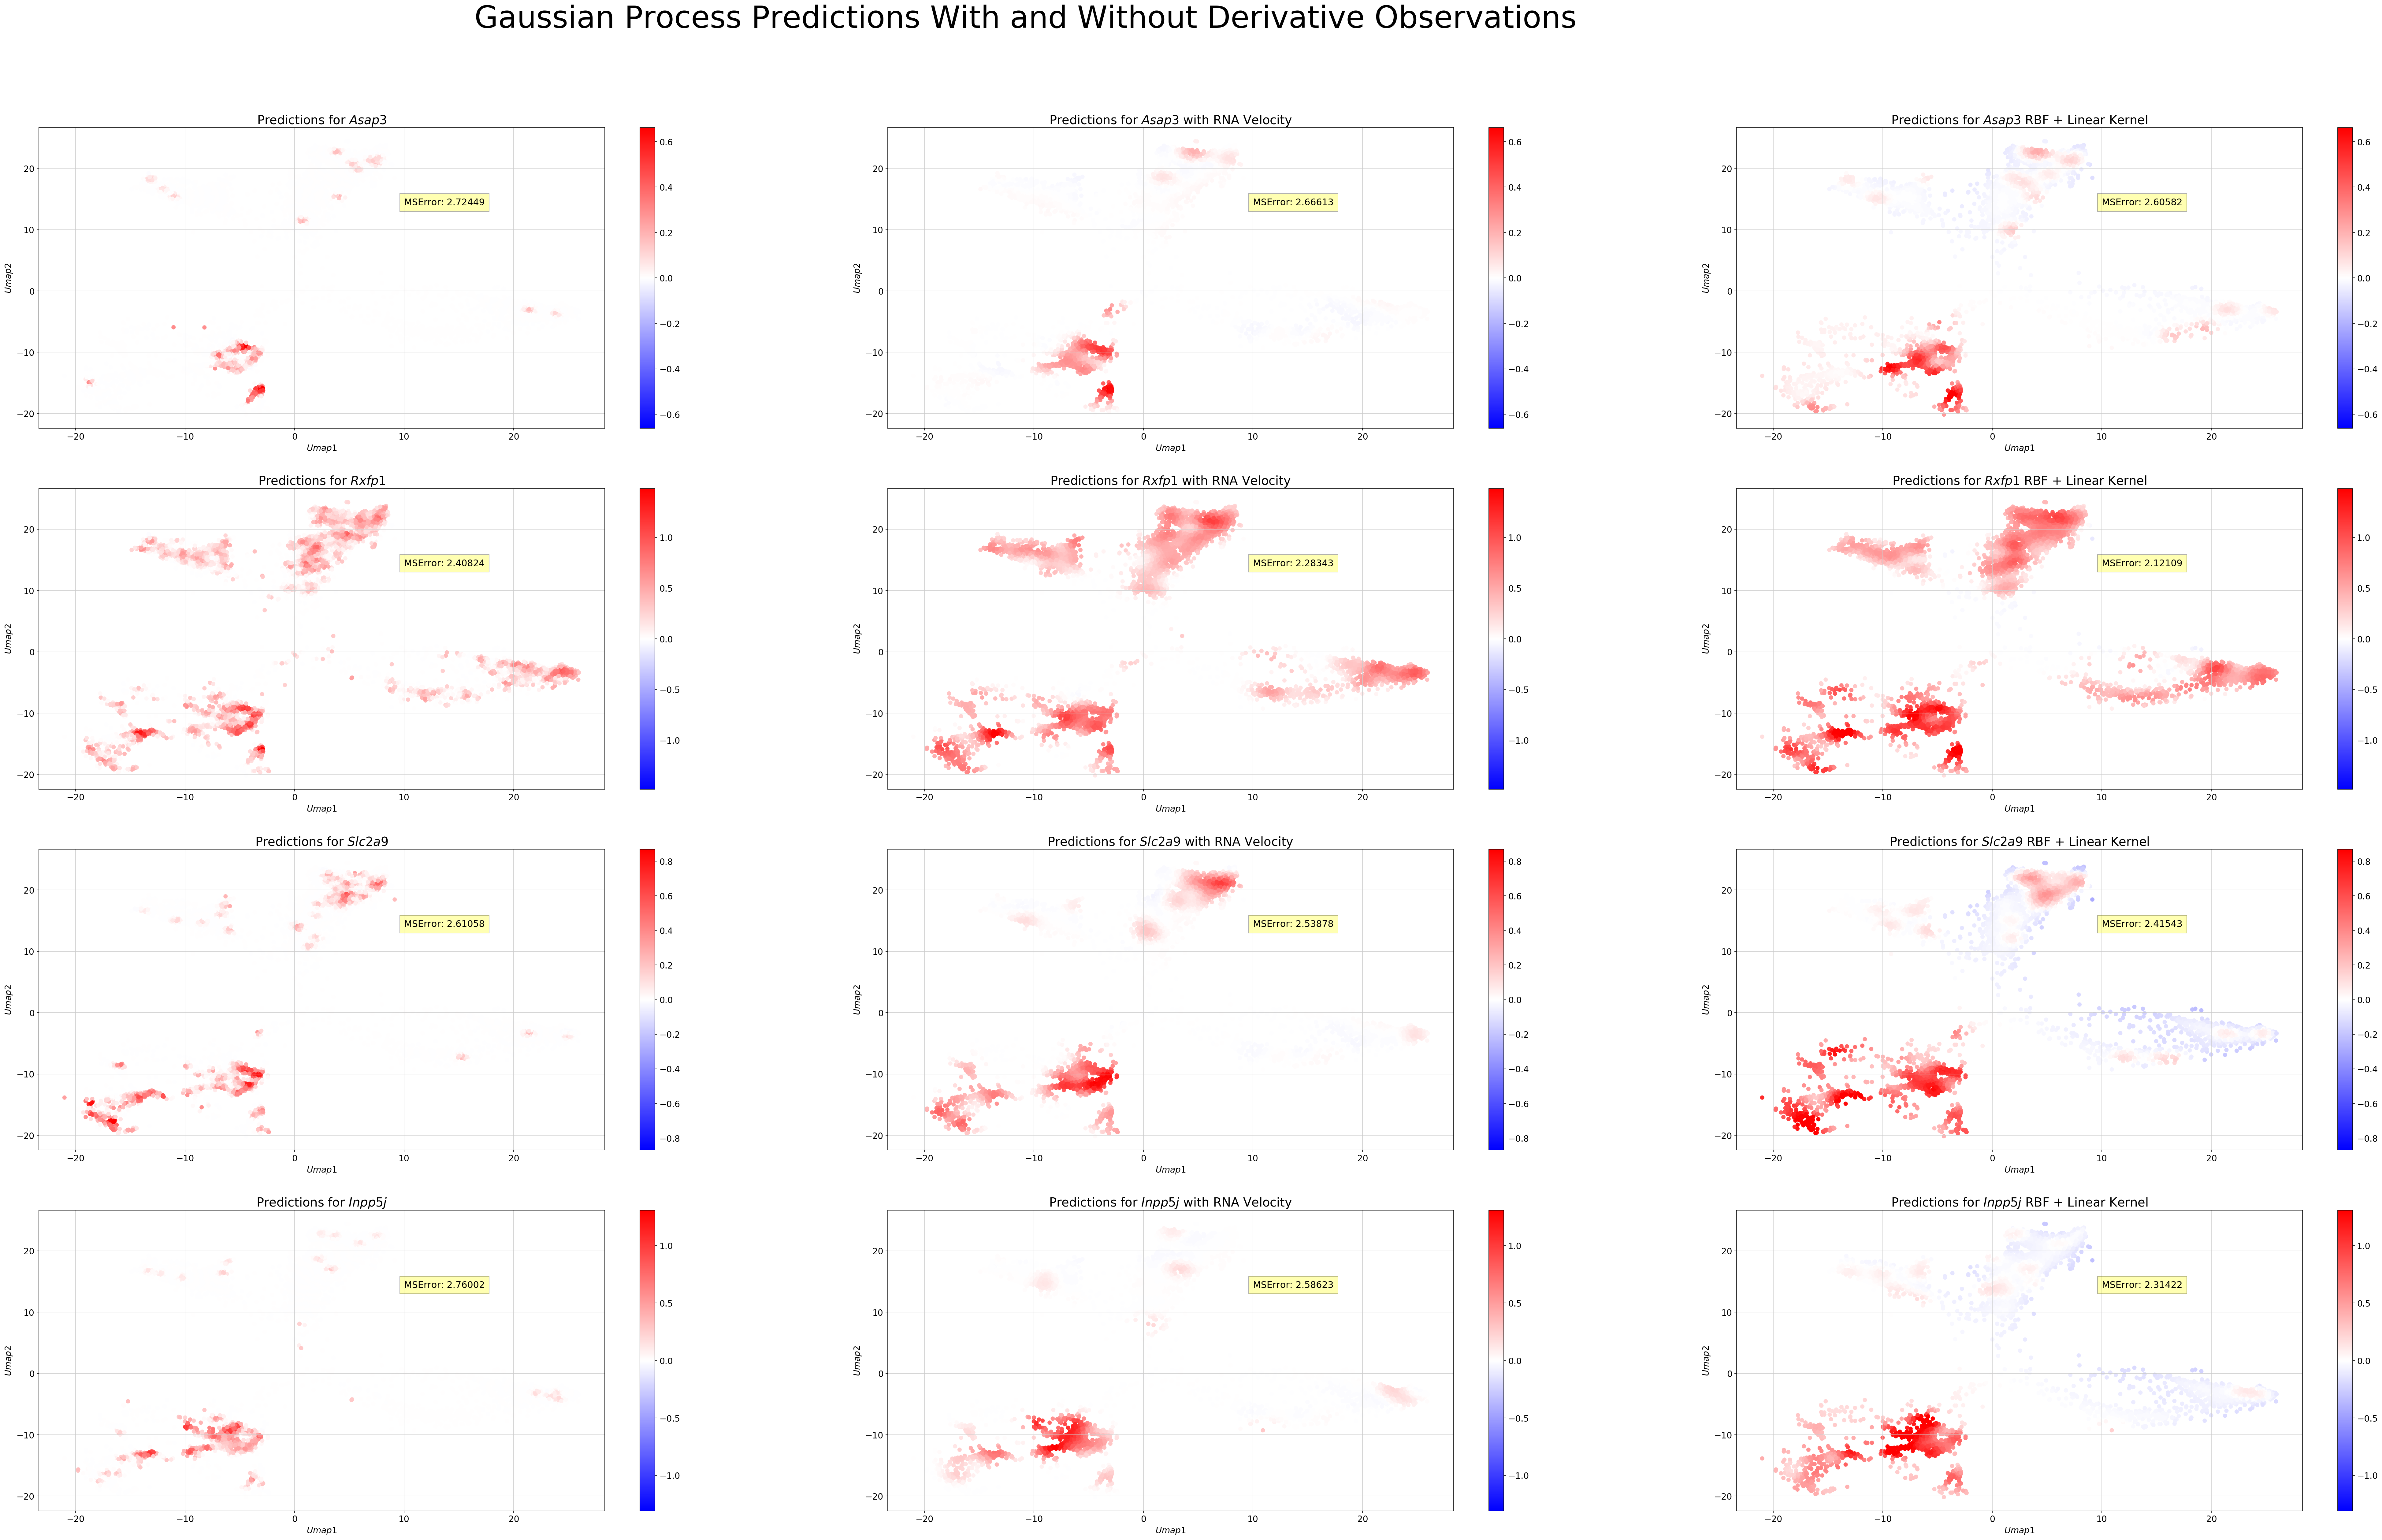

In [128]:
%matplotlib inline
fig, axs = plt.subplots(4, 3, figsize=(70,40))
dy_x1 = adata.obsm["velocity_tsne"][:, 0] 
dy_x2 = adata.obsm["velocity_tsne"][:, 1] 
X = adata.obsm["X_tsne"][:, :2]
 
for i, gene in enumerate(['Asap3', 'Rxfp1', 'Slc2a9', 'Inpp5j', 'Cntnap1', 'Rarb', 'Ap1s3'][:4]):

    y = adata.X[:, genes[gene]].A.reshape(-1)
    gp.fit(X, y.reshape(-1, 1), sample_ratio=.4)
    pred = gp.predict(X)
    gp_error = loss(y, pred.reshape(-1), penalize_0s=False)
    
    Y = np.hstack((y.reshape(-1), dy_x1, dy_x2))
    gp_do.fit(X, Y.reshape(-1, 1), sample_ratio=.2)
    pred_do = gp_do.predict(X)
    gp_do_error = loss(y, pred_do.reshape(-1), penalize_0s=False)

    gp_combined.fit(X, y.reshape(-1, 1), sample_ratio=.4)
    pred_combined = gp_combined.predict(X)
    gp_combined_error = loss(y, pred_combined.reshape(-1), penalize_0s=False)
    
    _min, _max = min(pred_do), max(pred_do)

    p = axs[i][0].scatter(X[:, 0], X[:, 1],  c=pred.reshape(-1), vmin=-_max, vmax=_max, cmap='bwr')
    axs[i][0].text(10, 14, 'MSError: {:.5f}'.format(gp_error),
        bbox={'facecolor': 'yellow', 'alpha': 0.3, 'pad': 7}, fontsize=15)
    axs[i][0].set_xlabel('$Umap1$')
    axs[i][0].set_ylabel('$Umap2$')
    axs[i][0].set_title("Predictions for ${gene}$".format(gene=gene), fontsize=20)
    fig.colorbar(p, ax=axs[i][0])

    p = axs[i][1].scatter(X[:, 0], X[:, 1],  c=pred_do.reshape(-1), vmin=-_max, vmax=_max, cmap='bwr')
    axs[i][1].text(10, 14, 'MSError: {:.5f}'.format(gp_do_error),
        bbox={'facecolor': 'yellow', 'alpha': 0.3, 'pad': 7}, fontsize=15)
    axs[i][1].set_xlabel('$Umap1$')
    axs[i][1].set_ylabel('$Umap2$')
    axs[i][1].set_title("Predictions for ${gene}$ with RNA Velocity".format(gene=gene), fontsize=20)
    fig.colorbar(p, ax=axs[i][1])
    

    p = axs[i][2].scatter(X[:, 0], X[:, 1],  c=pred_combined.reshape(-1), vmin=-_max, vmax=_max, cmap='bwr')
    axs[i][2].text(10, 14, 'MSError: {:.5f}'.format(gp_combined_error),
        bbox={'facecolor': 'yellow', 'alpha': 0.3, 'pad': 7}, fontsize=15)
    axs[i][2].set_xlabel('$Umap1$')
    axs[i][2].set_ylabel('$Umap2$')
    axs[i][2].set_title("Predictions for ${gene}$ RBF + Linear Kernel".format(gene=gene), fontsize=20)
    fig.colorbar(p, ax=axs[i][2])
    
#     scv.pl.velocity_embedding_grid(adata, density = 0.4, basis='X_umap', color=gene, color_map="Blues",
#                                    size=300, alpha=0.3, arrow_length=3, arrow_size=2.3, colorbar=True,
#                                    show=False, ax=axs[i][3],
#                                    title="Actual values for ${gene}$ with RNA Velocity".format(gene=gene),
#                                    fontsize=20)
    
fig.suptitle("Gaussian Process Predictions With and Without Derivative Observations",  fontsize=50)   
fig.savefig("dentate_gyrus_custom_top_3_smoothest_genes_3_models.png", transparent=False)

[-2.5, 2, 9, 15]

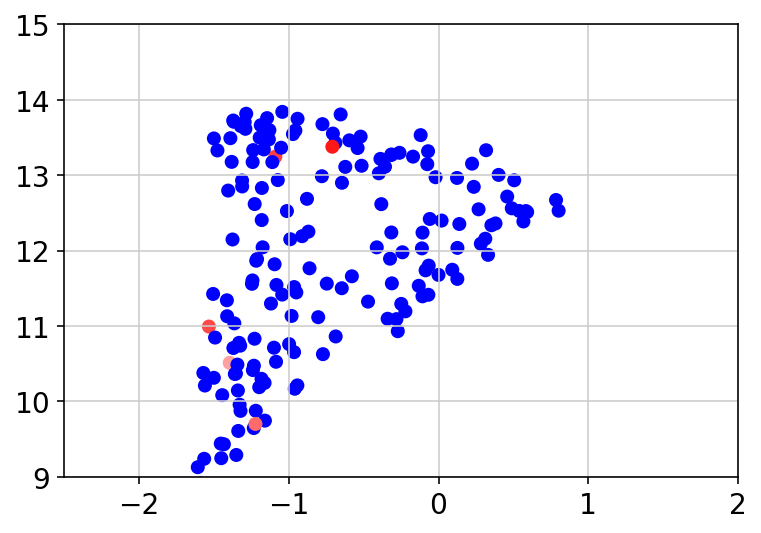

In [36]:
x = X[:, 0]
y = X[:, 1]
z = adata.X[:, genes["Ephb4"]].A.reshape(-1)
p = plt.scatter(x, y, c=z, cmap='bwr')
xmin, xmax, ymin, ymax = -2.5, 2, 9, 15
plt.axis([xmin, xmax, ymin, ymax])

# Analyse Genes Rankings For Each Model

In [121]:
genes = {key:idx for idx, key in enumerate(list(zip(*sorted(list(lh.items()), key=lambda x:x[1], reverse=True)))[0])}
genes_do = {key:idx for idx, key in enumerate(list(zip(*sorted(list(lh_do.items()), key=lambda x:x[1], reverse=True)))[0])}
genes_combined = {key:idx for idx, key in enumerate(list(zip(*sorted(list(lh_combined.items()), key=lambda x:x[1], reverse=True)))[0])}

In [122]:
pos = {}
for key in lh.keys():
    pos[key] = genes_do[key] - genes[key]
    
print("GP vs GP + RNA Velocity".center(100))
print()
print("*********************************************************************************************".center(100))
print()
print("------------------------------------  UP  ------------------------------------\n\n", [gene for gene, p in pos.items() if p > 100])
print()
print("------------------------------------  DOWN  ------------------------------------\n\n", [gene for gene, p in pos.items() if p < -100])
print()
print("------------------------------------ UNCGANGED  ------------------------------------\n\n", [gene for gene, p in pos.items() if p == 0])

                                      GP vs GP + RNA Velocity                                       

   *********************************************************************************************    

------------------------------------  UP  ------------------------------------

 []

------------------------------------  DOWN  ------------------------------------

 []

------------------------------------ UNCGANGED  ------------------------------------

 ['Rgs20', 'Mybl1', 'Ogfrl1', 'Prim2', '2010300C02Rik', 'Creg2', 'Pantr1', 'Fhl2', 'Tex30', 'Col5a2', 'Stk17b', 'Rftn2', 'Klf7', 'Idh1', 'Acadl', 'Bard1', 'Fn1', 'Tns1', 'Ptprn', 'Resp18', 'Ap1s3', 'Serpine2', 'Sphkap', 'Pid1', 'Dner', 'Ngef', 'Hjurp', 'Pask', 'Dtymk', 'Rnf152', 'Inhbb', 'Epb41l5', 'Lypd1', 'Tmem163', 'Mcm6', 'Btg2', '5730559C18Rik', 'Nek7', 'Lhx9', 'Rgs2', 'Tsen15', 'Cacna1e', 'Xpr1', 'Tor1aip1', 'Soat1', 'Brinp2', 'Pappa2', 'Fmo1', 'Prrx1', 'Sft2d2', 'Nuf2', 'Vangl2', 'Atp1a2', 'Kcnj9', 'Grem2', '6330403A02Rik', '

In [123]:
pos = {}
for key in lh.keys():
    pos[key] = genes_combined[key] - genes[key] 
    
print("GP vs GP + Combined Kernel".center(100))
print()
print("*********************************************************************************************".center(100))
print()
print("------------------------------------  UP  ------------------------------------\n\n", [gene for gene, p in pos.items() if p > 100])
print()
print("------------------------------------  DOWN  ------------------------------------\n\n", [gene for gene, p in pos.items() if p < -100])
print()
print("------------------------------------ UNCGANGED  ------------------------------------\n\n", [gene for gene, p in pos.items() if p == 0])

                                     GP vs GP + Combined Kernel                                     

   *********************************************************************************************    

------------------------------------  UP  ------------------------------------

 ['Rxrg', 'Gadd45b', 'Klf10', 'Abcd2', 'Tfap4', 'Nme5', 'Ivd', 'Col11a1', 'Klhl32', 'Serinc2', 'Hook1', 'Hs3st1', 'Kctd8', 'Orai1', 'Casp2', 'Blvrb', 'Raver1', '1190002N15Rik']

------------------------------------  DOWN  ------------------------------------

 ['Serpine2', 'Sphkap', 'Atp1a2', 'Cenpf', 'Prox1', 'Paqr8', '2810459M11Rik', 'Cntnap5a', 'Kcnj10', 'Cdk1', 'Tmpo', 'Gja1', 'Emid1', 'Camk2b', 'Hmmr', 'Sparc', 'Serpinf1', 'Top2a', 'Etv4', 'Tk1', 'Sox9', 'Slc9a3r1', 'Mis18bp1', 'Zfp36l1', 'Dio2', 'Bcl11b', 'Rrm2', 'Gmnn', 'Cks2', 'Esco2', 'Cmtm5', 'Slc1a3', 'Mlc1', 'Racgap1', 'Sema5a', 'Mpped1', 'Rbfox1', 'Ccdc80', 'Cyp1b1', 'Clic1', 'Pla2g7', 'Aqp4', 'Camk4', 'Camk2a', 'Gda', 'Ina', 'Camk1d', 'Notch1'

In [124]:
pos = {}
for key in lh.keys():
    pos[key] = genes_do[key] - genes_combined[key]
    
print("GP + RNA Velocity vs GP + Combined Kernel".center(100))
print()
print("*********************************************************************************************".center(100))
print()
print("------------------------------------  UP  ------------------------------------\n\n", [gene for gene, p in pos.items() if p > 100])
print()
print("------------------------------------  DOWN  ------------------------------------\n\n", [gene for gene, p in pos.items() if p < -100])
print()
print("------------------------------------ UNCGANGED  ------------------------------------\n\n", [gene for gene, p in pos.items() if p == 0])

                             GP + RNA Velocity vs GP + Combined Kernel                              

   *********************************************************************************************    

------------------------------------  UP  ------------------------------------

 ['Serpine2', 'Sphkap', 'Atp1a2', 'Cenpf', 'Prox1', 'Paqr8', '2810459M11Rik', 'Cntnap5a', 'Kcnj10', 'Cdk1', 'Tmpo', 'Gja1', 'Emid1', 'Camk2b', 'Hmmr', 'Sparc', 'Serpinf1', 'Top2a', 'Etv4', 'Tk1', 'Sox9', 'Slc9a3r1', 'Mis18bp1', 'Zfp36l1', 'Dio2', 'Bcl11b', 'Rrm2', 'Gmnn', 'Cks2', 'Esco2', 'Cmtm5', 'Slc1a3', 'Mlc1', 'Racgap1', 'Sema5a', 'Mpped1', 'Rbfox1', 'Ccdc80', 'Cyp1b1', 'Clic1', 'Pla2g7', 'Aqp4', 'Camk4', 'Camk2a', 'Gda', 'Ina', 'Camk1d', 'Notch1', 'Fam163b', 'Pde1a', 'Ckap2l', 'Aurka', 'Lypd6', 'Casc5', 'Nusap1', 'Snap25', 'Tpx2', 'S1pr1', 'Vcam1', 'Plppr4', 'Car2', 'Smc4', 'Pbxip1', 'Tnc', 'Cdc20', 'Runx1t1', 'Ldb2', 'Hopx', 'Cdk6', 'Fgfr3', 'Ppp2r2c', 'Slc4a4', 'Lfng', 'Pon2', 'Foxp1', 'Grin2b', 'Pt

### Results from Mean Squared Error 

    1. GP vs GP + RNA Velocity: The value of t is -13.20413. The value of p is < .00001. 
    The result is significant at p < .05.

    2. GP vs GP + Combined Kernel: The value of t is 13.87756. The value of p is < .00001. 
    The result isignificant at p < .05.
        
    3. GP + RNA Velocity vs GP + Combined Kernel: The value of t is 19.027366. The value of p is < .00001. 
    The result is significant at p < .05.

# Analyse The Genes That Changed The Most

In [34]:
pos = {}
for key in lh.keys():
    pos[key] =  genes_do[key] - genes[key]

# Compare Identified Genes by Models to Highly Variable Genes

In [98]:
sc.pp.highly_variable_genes(adata)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [99]:
higly_variable = [gene for gene in adata.var["highly_variable"].index if adata.var["highly_variable"][gene]]